# Тестовое задание

# Libs

In [1]:
import sqlite3
from sqlalchemy import create_engine

from scipy import stats as st
from statsmodels.stats.proportion import proportions_ztest

from collections import Counter

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.utils import class_weight, shuffle
from sklearn.feature_selection import mutual_info_classif
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, f1_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ShuffleSplit, GridSearchCV
from sklearn.feature_selection import RFE
from catboost import CatBoostClassifier
from catboost import Pool

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import phik
from phik.report import plot_correlation_matrix
from phik import report

import pylab
import optuna
import shap
import math as mth
import warnings
import pprint
import seaborn as sns
import requests
import json


sns.set_style('darkgrid')
warnings.filterwarnings("ignore", category=DeprecationWarning)
np.random.seed(42)

# 1. SQL задание

In [2]:
sqlite3.sqlite_version

'3.37.2'

Имеем две таблицы со следующими признаками:

Кодификатор:	  


`DEPARTMENT.NAME`	Название отдела  
`EMPLOYEE.ID`	ID сотрудника  
`EMPLOYEE.CHIEF_ID`	ID руководителя  
`EMPLOYEE.NAME`	Имя сотрудника  
`EMPLOYEE.SALARY`	Зарплата  


In [3]:
con = sqlite3.connect("sql_exercise.db")
cur = con.cursor()

def select(sql):
  return pd.read_sql(sql, con)

Таблица Employee:

In [4]:
sql = '''

        SELECT *
        FROM   Employee t
        LIMIT  5
        
        '''

In [5]:
select(sql)

,id,department_id,chief_id,name,salary
0,1,11,7,tvjozjoxmm,39336
1,2,2,6,jwhhhlobdc,55793
2,3,21,8,wwadqkvekx,42394
3,4,25,7,nqjfjyyqwh,46554
4,5,21,7,xitsddxurm,45971


Таблица Department

In [6]:
sql = '''

        SELECT *
        FROM   Department t
        LIMIT  5
        
        '''

In [7]:
select(sql)

,id,name
0,1,A
1,2,B
2,3,C
3,4,D
4,5,E


##	1.1. 

Вывести список сотрудников, получающих заработную плату выше 50000. Формат вывода - список ID

In [8]:
sql = '''

        SELECT DISTINCT t.id
        FROM   Employee t
        WHERE t.salary > 50000
        --LIMIT 5
        '''

In [9]:
select(sql)

,id
0,2
1,10
2,13
3,15
4,19
5,21
6,22
7,23
8,24
9,27


<a href="#footer"> Наверх </a>
<footer id="footer"></footer>

___

##	1.2.

Вывести названия всех отделов, где количество сотрудников, зарабатывающих более 50000, менее пяти. Вывести поля: Название отдела, количество сотрудников. 

In [10]:
sql = '''

          WITH aggr
              AS (SELECT t.department_id,
                          d.NAME,
                          Count(1) AS cnt
                  FROM   employee t
                          JOIN department d
                            ON d.id = t.department_id
                  WHERE  t.salary > 50000
                  GROUP  BY d.NAME
                  HAVING cnt < 5)
          SELECT t.NAME,
                CASE
                  WHEN a.cnt IS NULL THEN 0
                  ELSE a.cnt
                END AS cnt
          FROM   department t
                LEFT JOIN aggr a
                        ON a.department_id = t.id
       
        
        '''

In [11]:
select(sql)

,name,cnt
0,A,3
1,B,1
2,C,1
3,D,0
4,E,2
5,F,0
6,G,1
7,H,0
8,I,2
9,J,3


## 1.3. 

Вывести список сотрудников с минимальной заработной платой в своих отделах в формате ID, ФИО, Название отдела

In [12]:
sql = '''
        WITH min_salary AS 
        (SELECT t.id, t.name, t.salary, d.name AS dep_name,
        min(t.salary) over (partition by t.department_id) AS dep_min_salary
        FROM   Employee t
        JOIN   Department d on t.department_id = d.id)

        SELECT t.id as ID, t.name as surname, t.dep_name AS department_name 
        FROM min_salary t
        WHERE t.salary = dep_min_salary
        ORDER by t.ID

        
        '''

In [13]:
select(sql)

,ID,surname,department_name
0,3,wwadqkvekx,U
1,7,kfupupfgwy,W
2,8,elyvwoupwe,N
3,9,mglchhjwhy,O
4,12,laievcgkjv,Y
5,17,kvcpxrvhas,I
6,18,blielhrmeg,C
7,25,lpyyutzilh,B
8,28,uxdnptpbgg,Q
9,32,nlyvtvbzey,J


# 2.	API

С помощью запроса к методу `/characters` API `https://anapioficeandfire.com/`, нужно составить список актёров, чьи персонажи из Вестероса и живы (`culture=Westeros`, `isAlive=true`). 

In [14]:
session = requests.Session()
url = "https://anapioficeandfire.com/api/characters/" 


def get_jobs():
    first_page = session.get(url).json()
    yield first_page
    try:
      num_pages = first_page['last_page']
    except:
      num_pages = 0

    for page in range(2, num_pages + 1):
        next_page = session.get(url, params={'page': page}).json()
        yield next_page

for page in get_jobs():
    params = {"culture":"Westeros", 
              "died":"", 
              "isAlive": True
              }

    response = requests.get(url=url, params=params, timeout=5)
    actors = json.loads(response.text) 
    actors_list = [name['playedBy'] if name['playedBy'] != [''] 
                   else [f"Нет информации для {name['name']}"] for name in actors]
    flat_list = [item for sublist in actors_list for item in sublist]

In [15]:
flat_list

['Natalie Dormer',
 'Нет информации для Arstan Selmy',
 'Ian McElhinney',
 'Mark Stanley',
 'Wilko Johnson',
 'Нет информации для Jeyne Darry',
 'Нет информации для Mary Mertyns',
 'Liam Cunningham',
 'Нет информации для Jeyne Waters',
 'Нет информации для Shiera Seastar']

# 3. Статистика

Был проведен A/B-тест на конверсию. Объемы групп одинаковые, по 500 клиентов. В группе А случилось 99 целевых событий; в группе В - 101. Какие выводы мы можем сделать на основе этих данных? Какая дополнительная информация может быть полезна, на что еще стоит обратить внимание?

```
В группе А - 500 пользователей, 99 успех  
В группе В - 500 пользователей, 101 успех

```

Необходимо проверить, является ли разница - статистически значимой. Порог обозначим равный 5%, то есть наша уверенность 95%. Воспользуемся Z-критерием для разности двух долей из библиотеки statsmodels и проведем проверку самостоятельно:

In [16]:
alpha = .05

success = np.array([99, 101])
trials = np.array([500, 500])
stat, pval = proportions_ztest(success, trials, alternative='two-sided')

if pval < alpha:
    print(f"{round(pval, 2)}. Отвергаем Н0")
else:
    print(f"{round(pval, 2)}. Не отвергаем Н0. События могут носить случайный характер")

0.87. Не отвергаем Н0. События могут носить случайный характер


In [17]:
es = sms.proportion_effectsize(0.198, 0.202)
sample_size = round(sms.NormalIndPower().solve_power(es, power=0.80, alpha=0.05))
print(f'Минимальный размер сампла для улавливания эффекта в 0.4% - {sample_size}')

Минимальный размер сампла для улавливания эффекта в 0.4% - 156974


Какова вероятность получить такое отличие или больше. Так как распределение статистики нормальное, применим метод `cdf()`. Саму статистику возьмём по модулю методом `abs()` - проведем тот же самый тест, но сделаем это без готовых решений:

In [18]:
sample_1 = success[0]/trials[0]
sample_2 = success[1]/trials[1]

sample_combined = (success[0] + success[1]) / (trials[0] + trials[1])
difference = sample_1 - sample_2

z_value = difference / mth.sqrt(sample_combined * (1 - sample_combined) * (1/trials[0] + 1/trials[1]))

distr = st.norm(0, 1) 
p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
else:
    print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")


p-значение:  0.8743670611628918
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Вопросы:  

1. Какова базова конверсия?
2. Какое изменение мы хотим зафиксировать.
3. Вопросы к размерам выборки. Если принять, что базовая конверсия равна `99/500` и мы хотим зафиксировать изменение примерно в `0.4 %` - нам понадобится выборки размером `156974`
4. Также необходимо определиться с мощностью - `80%`, или `85%` или иную?

Таким образом, при тех показателях, что мы имеем значимой статистически разницы мы не обнаружили

Наши рассчеты подтверждает и калькулятор [Эвана Миллера](https://www.evanmiller.org/ab-testing/chi-squared.html):  

![](https://i.ibb.co/TMXhKC9/image.png)

# 4. Classic ML

`sample.xlsx` содержится таблица с данными по 5000 клиентов в следующей кодификации:		

•	`No` : Порядковый номер клиента				
•	`predictor1-7*` : Фичи (предикторы) по которым необходимо построить модель. 
•	`Target` : Целевая бинарная переменная, обозначающая факт дефолта клиента	  

  
Задачи:   


1)	Необходимо построить модель, позволяющую предсказывать вероятность дефолта клиента. Предлагается построить 2 конкурирующие модели (например, логистическая регрессия и дерево решений) и произвести выбор наилучшей модели на основе предложенного вами показателя качества.	 
2)	Продемонстрируйте силу отдельных предикторов, используя предложенный вами метод. Постройте модель используя только 3 предиктора. Допускается создание своих фичей на основе имеющихся.   
3)	Напишите класс транформер совместимый с пайплайном `sklearn`, который проведет отбор (или преобразование) предикторов. То есть количество полученных предикторов будет параметром этого класса (возможно и увеличение количества фичей). Сделайте sklearn пайплайн, где одним из шагов будет применяться этот класс. 


In [19]:
def get_info(data):
    display(data.head())
    display(data.describe().T)
    print('----')
    print('Информация о пропусках и типах данных')
    print('----')
    print()
    display(data.info())
    print('----')
    print()


def split_data(data, target_column):
    return data.drop(columns=[target_column], axis=1), data[target_column]


def qq_plt(data):
  measurements = data
  st.probplot(measurements, dist="norm", plot=pylab)
  plt.title('QQ-график')
  plt.xlabel('Теоретические квантили')
  plt.ylabel('Упорядоченые значения')
  pylab.show()

def kde_plot(data, col):
  plt.figure(figsize=(10,5))
  sns.kdeplot(data=data, shade=True, 
                 alpha=.5, linewidth=4.2
  )
  plt.xlabel(f"{col}")
  plt.title('KDE оценка плотности')
  plt.show()

## Загрузка данных и первичный осмотр

In [20]:
df = pd.read_excel('sample.xlsx', sheet_name='Sheet1')
df

,No,predictor 1,predictor 2,predictor 3,predictor 4,predictor 5,predictor 6,predictor 7,target
0,1,12423,710,441.5,5,4631.0,D4,B1,1
1,2,13983,1106,NaN,3,4256.0,D5,B1,1
2,3,15520,1276,391.5,1,4397.0,NaN,B1,0
3,4,29535,1106,NaN,1,3772.0,D4,B2,1
4,5,26154,976,315.0,5,2445.0,D3,B1,1
...,...,...,...,...,...,...,...,...,...
9995,9996,17220,1450,421.5,3,1759.0,D3,B2,0
9996,9997,6173,1100,NaN,1,4521.0,D5,B1,0
9997,9998,41944,1122,311.0,13,4087.0,D2,B2,0
9998,9999,28381,1314,182.0,1,4439.0,D1,B2,1


In [21]:
get_info(df)

,No,predictor 1,predictor 2,predictor 3,predictor 4,predictor 5,predictor 6,predictor 7,target
0,1,12423,710,441.5,5,4631.0,D4,B1,1
1,2,13983,1106,NaN,3,4256.0,D5,B1,1
2,3,15520,1276,391.5,1,4397.0,NaN,B1,0
3,4,29535,1106,NaN,1,3772.0,D4,B2,1
4,5,26154,976,315.0,5,2445.0,D3,B1,1


,count,mean,std,min,25%,50%,75%,max
No,10000.0,5000.500000,2886.895680,1.0,2500.750,5000.5,7500.250,10000.0
predictor 1,10000.0,20107.924800,12679.903068,7.0,9651.250,18850.0,28010.500,49996.0
predictor 2,10000.0,1123.810200,146.337209,564.0,1050.000,1106.0,1214.000,1450.0
predictor 3,8087.0,368.662174,68.536786,62.0,325.000,377.5,419.000,512.5
predictor 4,10000.0,3.490400,3.827607,1.0,1.000,3.0,5.000,49.0
predictor 5,10000.0,2518.598750,1447.114231,0.5,1261.375,2536.5,3765.125,5000.0
target,10000.0,0.195500,0.396605,0.0,0.000,0.0,0.000,1.0


----
Информация о пропусках и типах данных
----

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   No           10000 non-null  int64  
 1   predictor 1  10000 non-null  int64  
 2   predictor 2  10000 non-null  int64  
 3   predictor 3  8087 non-null   float64
 4   predictor 4  10000 non-null  int64  
 5   predictor 5  10000 non-null  float64
 6   predictor 6  8522 non-null   object 
 7   predictor 7  10000 non-null  object 
 8   target       10000 non-null  int64  
dtypes: float64(2), int64(5), object(2)
memory usage: 703.2+ KB


None

----



В работе сет с обфусцированными данными, 9 признаков.  

`No` : Порядковый номер клиента  
`predictor1-7` : признаки по которым необходимо построить модель.  
`Target` : Целевая бинарная переменная, обозначающая факт дефолта клиента  

Наблюдаются пропуски в признаках `predictor 3`, `predictor 6`. Подумаем, что с ними делать после анализа - заполнять средним, модой, предыдущим - довольно проблематично, если не знать значение признаков. Уточнить возможную причину появления - возможно не худшгий вариант сейчас - обучать удалив строки с пропусками либо ввести новое обозначение.   


Колонки переименуем для удобства


In [22]:
df.drop('No', axis=1, inplace=True)

In [23]:
df.columns = (df.columns
          .str.lower()
          .str.replace(' ','_')
        )

In [24]:
df.head()

,predictor_1,predictor_2,predictor_3,predictor_4,predictor_5,predictor_6,predictor_7,target
0,12423,710,441.5,5,4631.0,D4,B1,1
1,13983,1106,NaN,3,4256.0,D5,B1,1
2,15520,1276,391.5,1,4397.0,NaN,B1,0
3,29535,1106,NaN,1,3772.0,D4,B2,1
4,26154,976,315.0,5,2445.0,D3,B1,1


## Анализ данных

Посмотрим на пропуски:

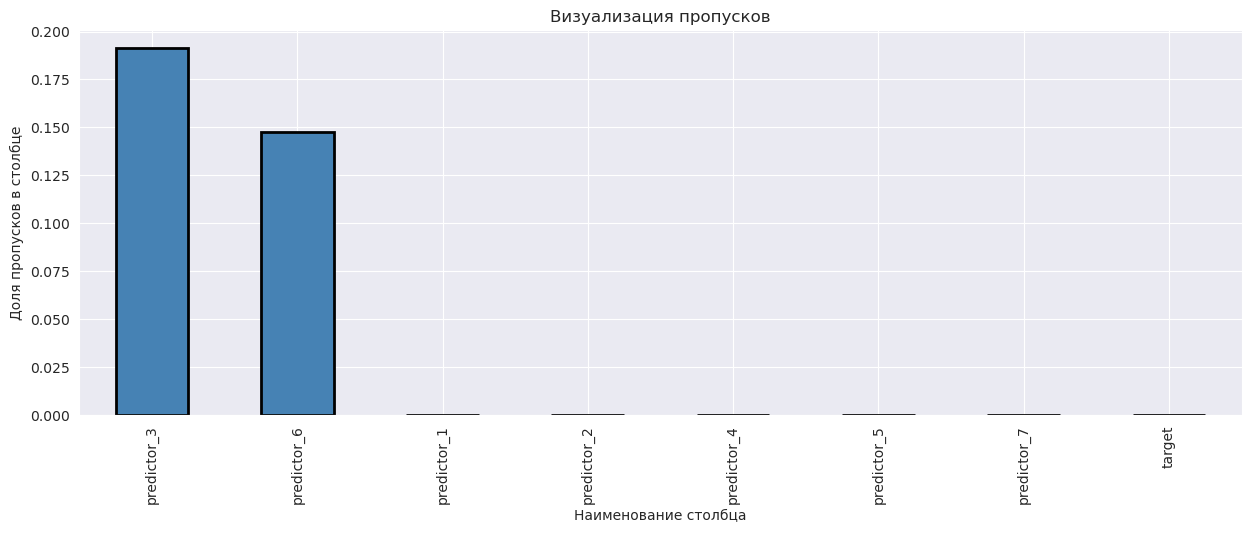

In [25]:
df.isna().mean().sort_values(ascending=False).plot(
    kind='bar', figsize=(15,5), 
    grid=True, color='steelblue', 
    edgecolor='black', linewidth=2
)
plt.title('Визуализация пропусков')
plt.xlabel('Наименование столбца')
plt.ylabel('Доля пропусков в столбце')
plt.show()

Посмотрим на категориальные признаки - среди них есть `predictor_6` - доля пропусков достаточно высокаая, чтобы не смещать оценку модели - возможно стоит удалить их на данном этапе. 

In [26]:
cols = ['predictor_6', 'predictor_7', 'target']

for col in cols:
  print(f'Признак {col}', '\n', df[col].value_counts(normalize=True, 
                                                     dropna=False))
  print('------------------------')

Признак predictor_6 
 predictor_6
D1     0.1776
D4     0.1732
D5     0.1715
D3     0.1711
D2     0.1588
NaN    0.1478
Name: proportion, dtype: float64
------------------------
Признак predictor_7 
 predictor_7
B2    0.5011
B1    0.4989
Name: proportion, dtype: float64
------------------------
Признак target 
 target
0    0.8045
1    0.1955
Name: proportion, dtype: float64
------------------------


В признаке `predictor_6` наблюдаем 14.78% пропусков. Если учесть что остальных значений 15-17% - то заполнять пропуски модой - будет нецелесообразно. На данном этапе, так как данных у нас немного, заменим пропуски на `D_unknown`

Также стоит отметить, что у целевой признак с дисбалансом классов. Только `Accuracy` для оценки качества модели применять нельзя: мы можем применть `ROC-AUC`, `F1` и `precision-recall curve`, так как у нас нет требований о важности `FP` - можем смотреть `ROC_AUC` и `Accuracy`

При подготовке признаков к обучению моделей, которые не работают напрямую с категориальными переменными - признак `predictor_6` будет кодироваться через `Ordinal_encoder`, признак `predictor_7` будет подготовлен с помощью `OHE`

Отделим целевую переменную от сета - выделим таргет и выборку с обучающими признаками

In [27]:
features, target = split_data(df, 'target')

Выделим для удобства анализа численные признаки и категориальные:

In [28]:
num_features = list(features.select_dtypes(include=['int64', 'float64']).columns)
cat_features = list(features.select_dtypes(exclude=['int64', 'float64']).columns)

In [29]:
num_features

['predictor_1', 'predictor_2', 'predictor_3', 'predictor_4', 'predictor_5']

Посмотрим на наши численные признаки

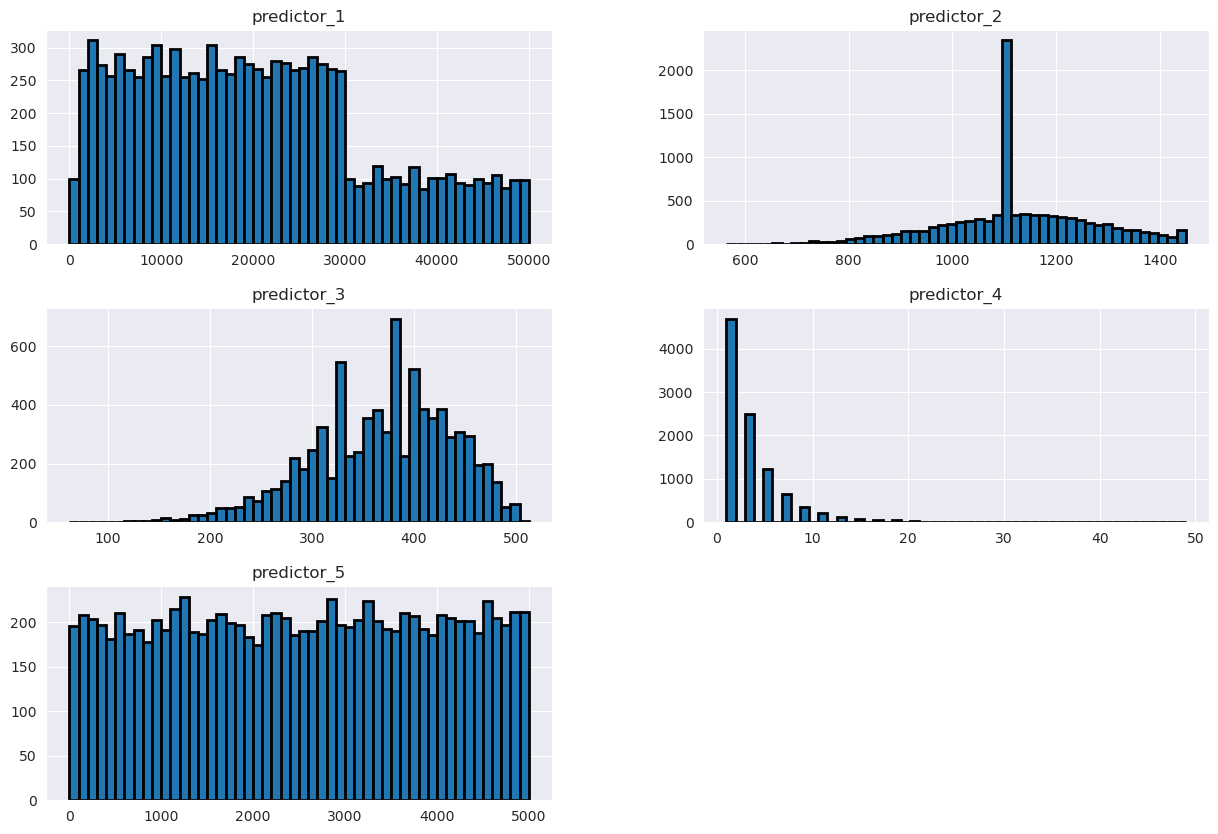

In [30]:
features[num_features].hist(bins=50, figsize=(15,10), edgecolor='black', linewidth=2)
plt.show()

Близко к нормальному распредлению только признак `predict_3`. Проверим с помощью QQ-графика

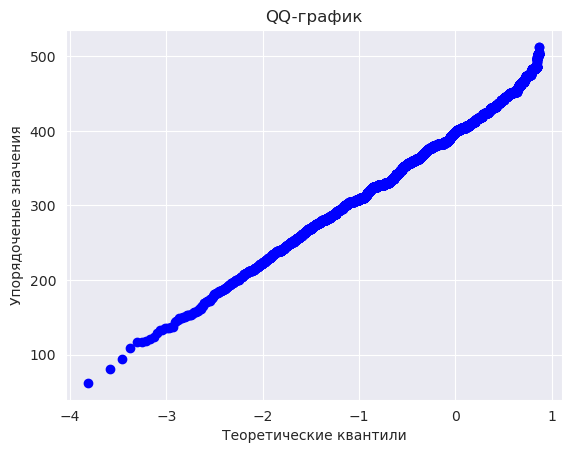

In [31]:
qq_plt(features['predictor_3'])

Наше предположение подтверждается - признак близок к нормальному распределению - но есть отрицательная ассиметрия. Так или иначе при обучении моделей будем применять Стандартизацию из `sklearn` - `StandardScaler()`. Пропуски заменим медианой

In [32]:
features[num_features].describe().T

,count,mean,std,min,25%,50%,75%,max
predictor_1,10000.0,20107.924800,12679.903068,7.0,9651.250,18850.0,28010.500,49996.0
predictor_2,10000.0,1123.810200,146.337209,564.0,1050.000,1106.0,1214.000,1450.0
predictor_3,8087.0,368.662174,68.536786,62.0,325.000,377.5,419.000,512.5
predictor_4,10000.0,3.490400,3.827607,1.0,1.000,3.0,5.000,49.0
predictor_5,10000.0,2518.598750,1447.114231,0.5,1261.375,2536.5,3765.125,5000.0


По другим признакам также будет использовать Стандартизацию. Посмотрим корреляцию - Пиррсона и phik-корреляцию

In [33]:
corr_check = df[num_features].copy()
plot_values = df[num_features+['target']].copy()

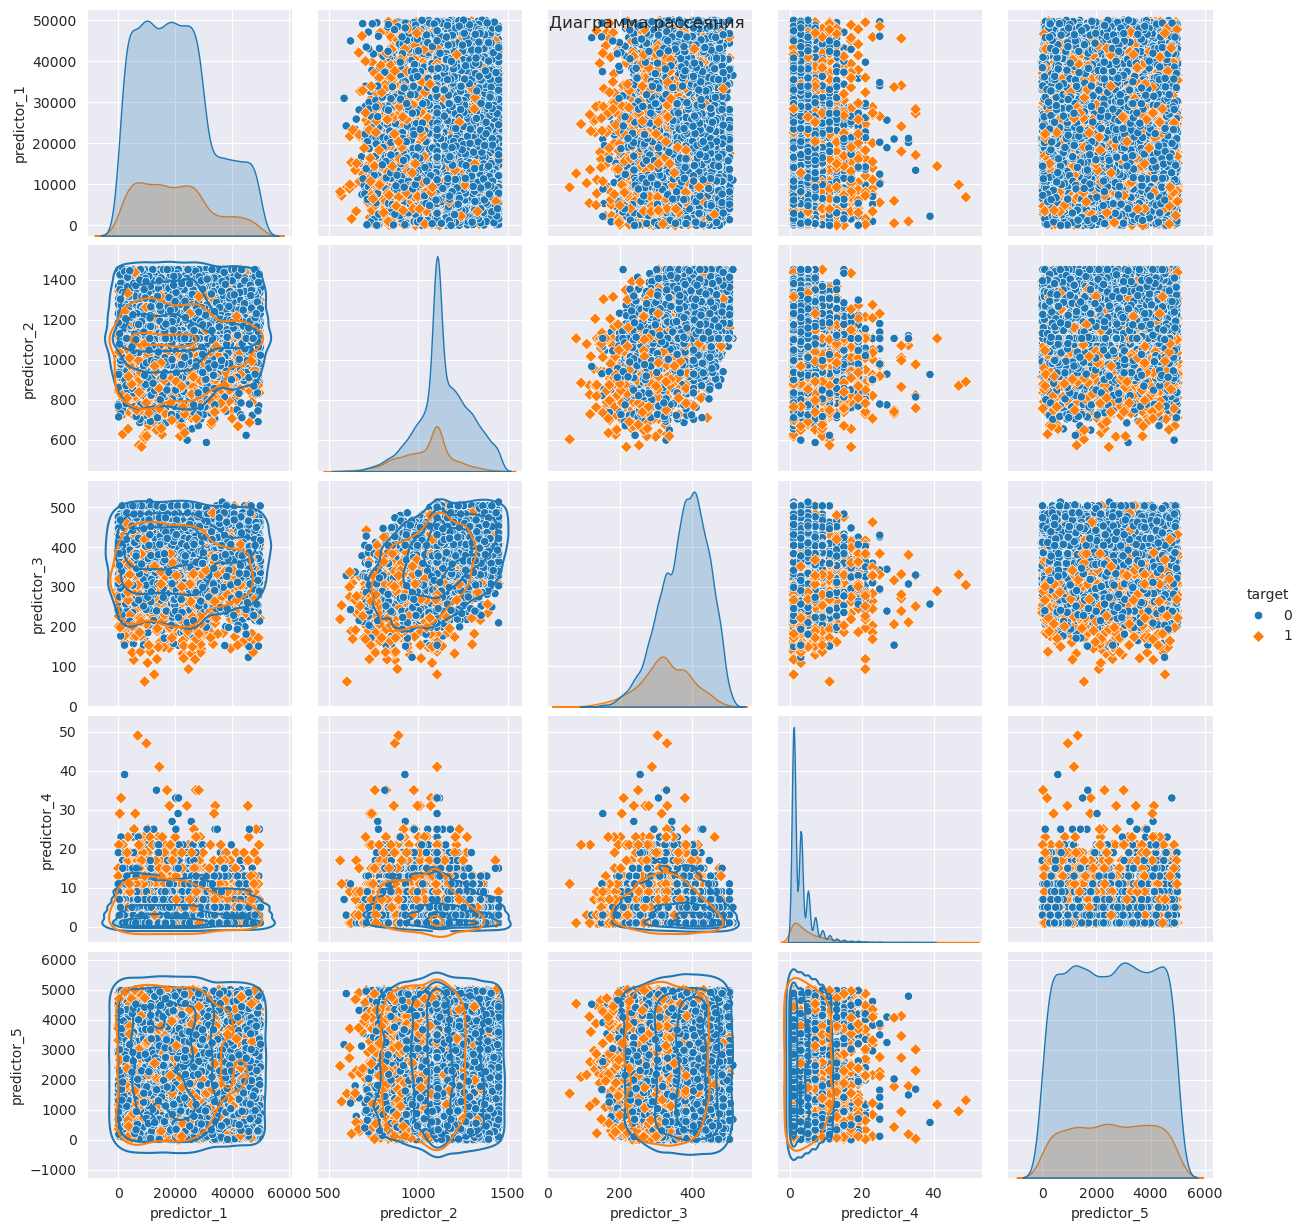

In [34]:
map_corr = sns.pairplot(plot_values, hue='target', markers=["o", "D"])
(map_corr.map_lower(sns.kdeplot, levels=4, color=".1")
.fig.suptitle('Диаграмма рассеяния'))
plt.show()

In [35]:
corr_check.corr(method='pearson')

,predictor_1,predictor_2,predictor_3,predictor_4,predictor_5
predictor_1,1.000000,0.024318,0.001142,-0.012252,0.002024
predictor_2,0.024318,1.000000,0.448976,-0.255252,-0.028135
predictor_3,0.001142,0.448976,1.000000,-0.254268,-0.010699
predictor_4,-0.012252,-0.255252,-0.254268,1.000000,-0.014792
predictor_5,0.002024,-0.028135,-0.010699,-0.014792,1.000000


Сильной корреляции не наблюдаем, согласно коэффициента Пиррсона. Обратимся к phik-корреляции, которая как заявлено - работает и с нелинейными зависимостями - и стоит отметить - с категориальными признаками также ([см. документацию](https://phik.readthedocs.io/en/latest/))

In [36]:
phik_overview = features[num_features].phik_matrix()
phik_overview.round(2)

interval columns not set, guessing: ['predictor_1', 'predictor_2', 'predictor_3', 'predictor_4', 'predictor_5']


,predictor_1,predictor_2,predictor_3,predictor_4,predictor_5
predictor_1,1.00,0.03,0.02,0.03,0.03
predictor_2,0.03,1.00,0.49,0.29,0.00
predictor_3,0.02,0.49,1.00,0.26,0.00
predictor_4,0.03,0.29,0.26,1.00,0.00
predictor_5,0.03,0.00,0.00,0.00,1.00


Согласно phik-корреляции также не выявлено сильных зависимостей, удалять какие то признаки не требуется. Посмотрим также в разрезе категориальных и численных признаков

In [37]:
phik_overview = features.phik_matrix()
phik_overview.round(2)

interval columns not set, guessing: ['predictor_1', 'predictor_2', 'predictor_3', 'predictor_4', 'predictor_5']


,predictor_1,predictor_2,predictor_3,predictor_4,predictor_5,predictor_6,predictor_7
predictor_1,1.00,0.03,0.02,0.03,0.03,0.00,0.00
predictor_2,0.03,1.00,0.49,0.29,0.00,0.01,0.05
predictor_3,0.02,0.49,1.00,0.26,0.00,0.06,0.00
predictor_4,0.03,0.29,0.26,1.00,0.00,0.02,0.00
predictor_5,0.03,0.00,0.00,0.00,1.00,0.00,0.00
predictor_6,0.00,0.01,0.06,0.02,0.00,1.00,0.08
predictor_7,0.00,0.05,0.00,0.00,0.00,0.08,1.00


Теперь обратимся к взаимной информации - посмотрим, сколько содержится в категориальных и целоцисленных признаках о целевой переменной

In [38]:
X = df.copy()
y = X.pop('target')
X.dropna(axis=1, inplace=True)


for col in list(X.select_dtypes(['object', 'category']).columns):
    X[col], _ = X[col].factorize()

discrete_features = X.dtypes == int

In [39]:
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name='mutual_information оценка', index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3].to_frame('Mi_scores')

,Mi_scores
predictor_1,0.446521
predictor_5,0.001605


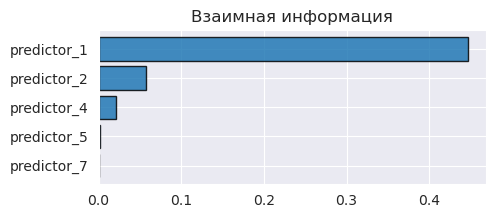

In [40]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores, ec='black', alpha=0.84)
    plt.yticks(width, ticks)
    plt.title('Взаимная информация')


plt.figure(dpi=100, figsize=(5, 2))
plot_mi_scores(mi_scores)

Согласно взаимной информации - самое сильное влияние оказывает `predictor_1`, также есть некоторое количество в `predictor_2` и `predictor_4`. Сравним данный результат с feature_importance модели и решим, какие признаки убирать. Посмотрим выбросы. Так как масштаб разный у признаков будет смотреть раздельно, для лучшей наглядности


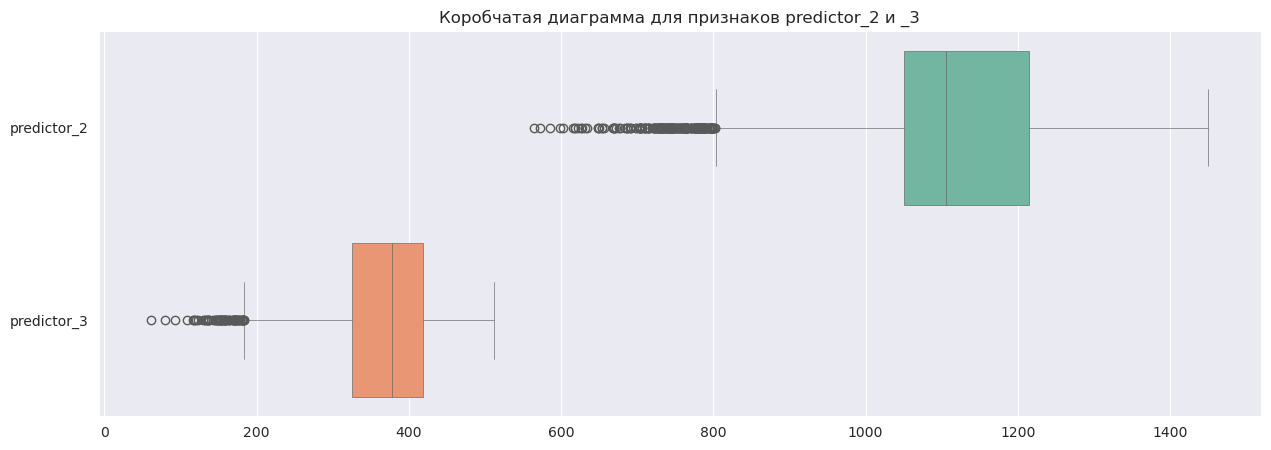

In [41]:
plt.figure(figsize=(15,5))
sns.boxplot(data=features[num_features[1:3]], linewidth=0.42, palette="Set2", orient='h')
plt.title('Коробчатая диаграмма для признаков predictor_2 и _3')
plt.show()

У признаков `_2` и `_3` наблюдаются выбросы. Выбросы лучше попробовать убрать, чтобы не получать смещение оценки.



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



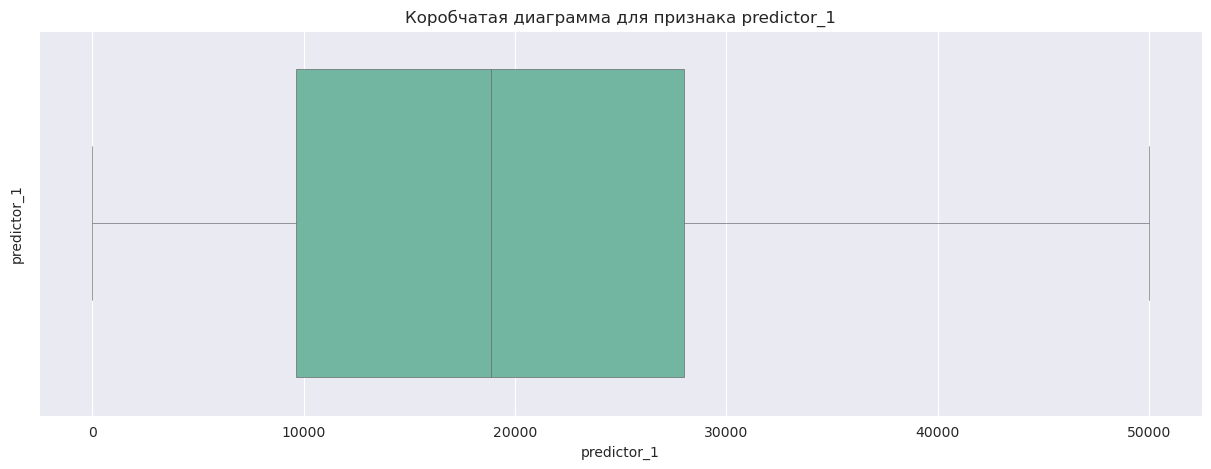

In [42]:
plt.figure(figsize=(15,5))
ax = sns.boxplot(data=features[num_features[0]], linewidth=0.42, palette="Set2", orient='h')
ax.set(ylabel='predictor_1')
plt.title('Коробчатая диаграмма для признака predictor_1')
plt.show()

Явных выбросов нет, проверим также признак _5:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



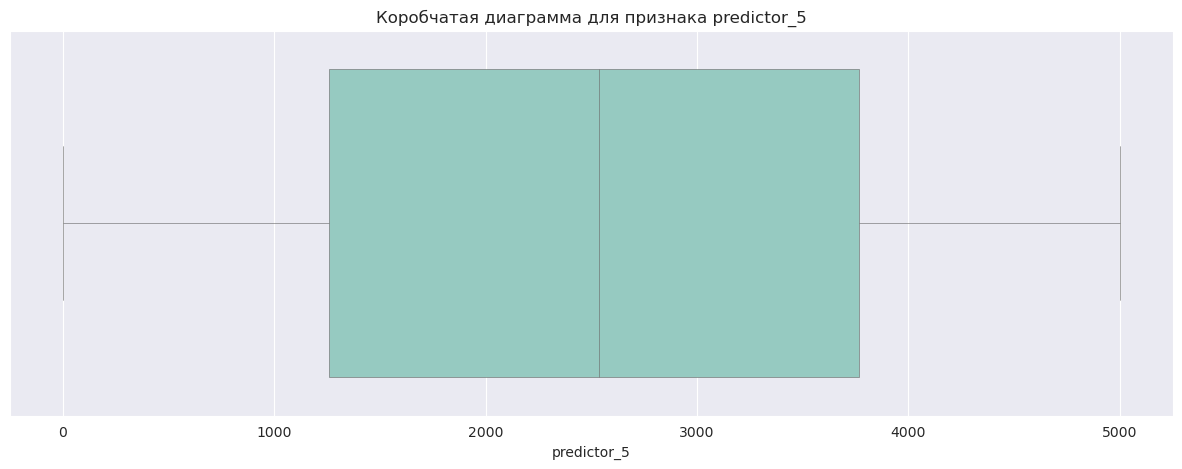

In [43]:
plt.figure(figsize=(15,5))
sns.boxplot(data=features[num_features[4]], linewidth=0.42, palette="Set3", orient='h')
ax.set(ylabel='predictor_5')
plt.title('Коробчатая диаграмма для признака predictor_5')
plt.show()

Получили аналогичные результаты

In [44]:
df.columns

Index(['predictor_1', 'predictor_2', 'predictor_3', 'predictor_4',
       'predictor_5', 'predictor_6', 'predictor_7', 'target'],
      dtype='object')

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   predictor_1  10000 non-null  int64  
 1   predictor_2  10000 non-null  int64  
 2   predictor_3  8087 non-null   float64
 3   predictor_4  10000 non-null  int64  
 4   predictor_5  10000 non-null  float64
 5   predictor_6  8522 non-null   object 
 6   predictor_7  10000 non-null  object 
 7   target       10000 non-null  int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 625.1+ KB


## Подготовка Pipeline предобработки

Планируется использование линейной модели `Логистической регрессии` и `Градиентного бустинга Catboost`. Для регрессии необходимо подготовить признаки, кэтбуст будет работать без подготовкию Требований ко времени обучения и предсказания нет - попробуем кросс-валидацию

`Pipeline` будет состоять из следующих компонентов:
1. Заполнять пропуски
2. `StandardScaler` для числовых признаков
3. `OrdinalEncoder` для порядковых признаков
4. `OneHotEncoder` для бинарных признаков


Данных немного - для начала пробуем обучать без удаления выбросов - стараюсь сэкономить все данные.


In [46]:
X_train , X_test , y_train , y_test, = train_test_split ( 
                                features, target, test_size=0.25, random_state=42)

assert X_train.shape[0] + X_test.shape[0] == features.shape[0], 'Формы выборок не равны. Проверить'

In [47]:
num_features = list(X_train.select_dtypes(include=['int64', 'float64']).columns)
cat_features = ['predictor_6']
binary_features = ['predictor_7']

In [48]:
def fill_nan(X):
  X_new = X.copy()
  nan_cols = [col for col in X_new.columns if X_new[col].isna().any()]
  for col in nan_cols:
    if col == 'predictor_6':
      X_new[col] = X_new[col].fillna('D_unknown')
    elif col == 'predictor_3':
      X_new[col] = X_new[col].fillna(X_new[col].median())
    else:
      pass
  return X_new

In [49]:
preprocessor = ColumnTransformer (
    transformers = [

        ('std_scaler' , StandardScaler() , num_features) ,
        ('cat' , OrdinalEncoder() , cat_features) ,
        ('binary' , OneHotEncoder(drop='first') , binary_features),
        
        
        ]
)

pipe = Pipeline(steps=
    
    [ ('fill_nan', FunctionTransformer(fill_nan, validate=False)),
     ('preprocessor', preprocessor),


     ]
)


In [50]:
X_train_prep = pipe.fit_transform(X_train)

In [51]:
X_train_prep[:5]

array([[-1.19042208, -2.49052326, -3.823775  ,  1.45288978,  0.93769814,
         1.        ,  1.        ],
       [ 0.16996442,  0.11024889, -0.71508699, -0.65539567, -0.63436621,
         5.        ,  1.        ],
       [ 1.80345822, -0.123683  ,  0.11281426, -0.65539567, -0.45738342,
         2.        ,  0.        ],
       [ 0.02861733,  1.45879741,  0.11281426, -0.65539567, -1.50127017,
         5.        ,  0.        ],
       [-0.50095887, -0.28881139, -0.66638691,  0.39874706,  0.06663803,
         3.        ,  1.        ]])

In [52]:
X_test_prep  = pipe.transform(X_test)

In [53]:
X_test_prep[:5]

array([[ 1.46221276,  0.70195895, -0.95858735,  0.39874706, -0.17753588,
         4.        ,  0.        ],
       [-1.18305365, -0.57778607, -1.03975414, -0.65539567,  1.41253846,
         0.        ,  1.        ],
       [ 0.54369437, -1.22453894,  0.23456444, -0.65539567, -1.15700228,
         1.        ,  1.        ],
       [-0.27443906, -0.1924865 ,  0.11281426, -0.12832431, -0.21875105,
         3.        ,  0.        ],
       [-0.68231732, -0.34385419,  0.14528098, -0.12832431,  1.58120895,
         1.        ,  0.        ]])

Получили ожидаемый результат. Создадим вспомогательные таблицы для подготовки отчета.

In [54]:
auc = []
accuracy = []
model_name = []

## Логистическая регрессия

### Логистическая регрессия базовая с GridsearchCV

In [55]:
model = LogisticRegression(class_weight='balanced', 
                           solver='liblinear', 
                           max_iter=500)


cv = ShuffleSplit(n_splits=5, test_size=0.25, random_state=42)
params_space = {'C': [100, 10, 1, 0.1, 0.01, 0.001],
                'penalty': ['l1', 'l2']}

grid_cv = GridSearchCV(model, params_space, scoring='roc_auc', cv=cv)
grid_cv.fit(X_train_prep, y_train)

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=42, test_size=0.25, train_size=None),
             estimator=LogisticRegression(class_weight='balanced', max_iter=500,
                                          solver='liblinear'),
             param_grid={'C': [100, 10, 1, 0.1, 0.01, 0.001],
                         'penalty': ['l1', 'l2']},
             scoring='roc_auc')

In [56]:
grid_cv.best_params_

{'C': 0.01, 'penalty': 'l2'}

In [57]:
estimator = grid_cv.best_estimator_

In [58]:
y_pred = estimator.predict_proba(X_test_prep)[:, 1]
y_bin = np.array((y_pred >= 0.5)*1)


accuracy.append(accuracy_score(y_test, y_bin))
auc.append(roc_auc_score(y_test, y_pred))
model_name.append((str(model.__class__.__name__)+str(' ')+str('с выбросами')))

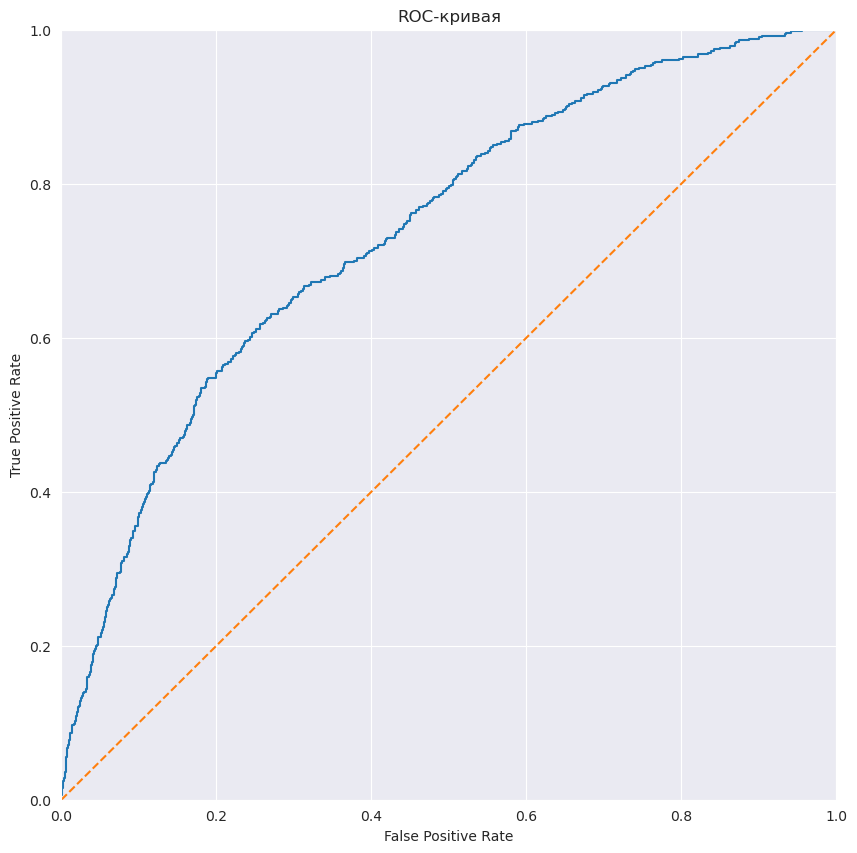

AUC: 0.7377418598229899
Accuracy 0.7096


In [59]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.show()


print('AUC:', roc_auc_score(y_test, y_pred))
print('Accuracy', accuracy_score(y_test, y_bin))


Достаточно низкий результат. Попробуем почистить выбросы, дальше преобразовать в pipeline и снова обучим

### Логистическая регрессия базовая с GridsearchCV, без выбросов

In [60]:
cols_clean = ['predictor_2', 'predictor_3']

low = .02
high = 1.
quant_df = df[cols_clean].quantile([low, high])
df_clean = df[cols_clean].apply(lambda x: x[(x > quant_df.loc[low, x.name]) & 
                                     (x < quant_df.loc[high, x.name])], axis=0)
df_clean.dropna(inplace=True)
df_clean.head()

,predictor_2,predictor_3
2,1276.0,391.5
4,976.0,315.0
5,1188.0,377.0
6,1308.0,380.0
7,1128.0,397.0


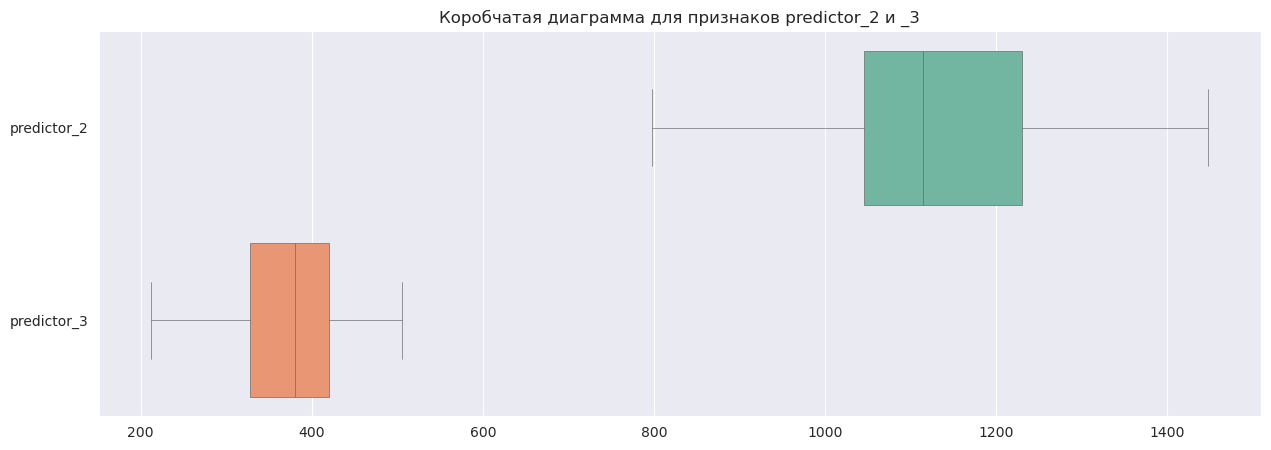

In [61]:
plt.figure(figsize=(15,5))
sns.boxplot(data=df_clean, linewidth=0.42, palette="Set2", orient='h')
plt.title('Коробчатая диаграмма для признаков predictor_2 и _3')
plt.show()

Очистили от выбросов. посмотрим как это повлияет на нашу модель. 

In [62]:
df_prep = df[df.index.isin(df.index)]

In [63]:
features_clean, target_clean = split_data(df_prep, 'target')

assert features_clean.shape[0] == target_clean.shape[0], 'Формы выборок не равны. Проверить'

In [64]:
X_train_clean , X_test_clean , y_train_clean , y_test_clean, = train_test_split ( 
                                features_clean, target_clean, test_size=0.25, random_state=42)

assert X_train_clean.shape[0] + X_test_clean.shape[0] == features_clean.shape[0], 'Формы выборок не равны. Проверить'

In [65]:
X_train_prep_clean = pipe.fit_transform(X_train_clean)

In [66]:
X_test_prep_clean = pipe.transform(X_test_clean)

In [67]:
model = LogisticRegression(class_weight='balanced', solver='liblinear', max_iter=500)

cv = ShuffleSplit(n_splits=5, test_size=0.25, random_state=42)
params_space = {'C': [100, 10, 1, 0.1, 0.01, 0.001],
                'penalty': ['l1', 'l2']}

grid_cv = GridSearchCV(model, params_space, scoring='roc_auc', cv=cv)
grid_cv.fit(X_train_prep_clean, y_train_clean)

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=42, test_size=0.25, train_size=None),
             estimator=LogisticRegression(class_weight='balanced', max_iter=500,
                                          solver='liblinear'),
             param_grid={'C': [100, 10, 1, 0.1, 0.01, 0.001],
                         'penalty': ['l1', 'l2']},
             scoring='roc_auc')

In [68]:
grid_cv.best_params_

{'C': 0.01, 'penalty': 'l2'}

In [69]:
estimator = grid_cv.best_estimator_

In [70]:
y_pred = estimator.predict_proba(X_test_prep_clean)[:, 1]
y_bin = (y_pred >= 0.5)*1

accuracy.append(accuracy_score(y_test, y_bin))
auc.append(roc_auc_score(y_test, y_pred))
model_name.append((str(model.__class__.__name__)+str(' ')+str('без выбросов')))

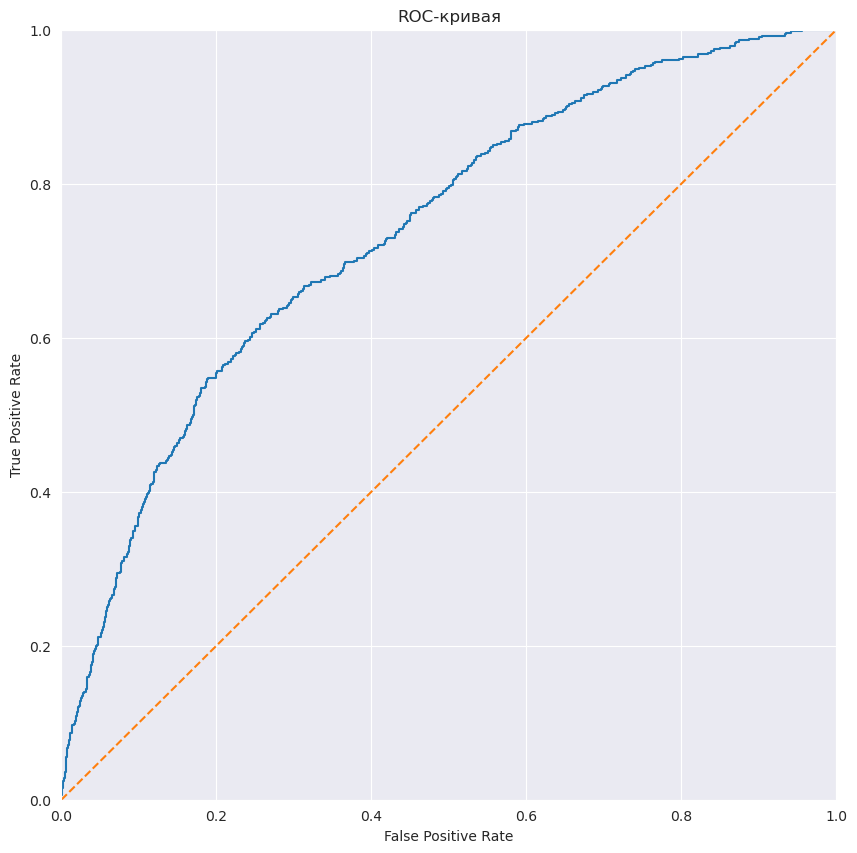

AUC: 0.7377418598229899
Accuracy 0.7096


In [71]:
fpr, tpr, thresholds = roc_curve(y_test_clean, y_pred)
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.show()

print('AUC:', roc_auc_score(y_test_clean, y_pred))
print('Accuracy', accuracy_score(y_test_clean, y_bin))

Так или иначе - результаты не улучшили. Взаимосвязи нелинейные - попробуем полиноминальные признаки, немного поменяв пайплайн, если улучшений заметных не будет - начнем работать с бустингом

### Логистическая регрессия базовая с GridsearchCV, без выбросов с полиноминальными признаками

In [72]:
preprocessor = ColumnTransformer (
    transformers = [
        ('poly_feature', PolynomialFeatures(degree=2, include_bias=False), num_features),
        ('std_scaler' , StandardScaler() , num_features) ,
        ('cat' , OrdinalEncoder() , cat_features) ,
        ('binary' , OneHotEncoder(drop='first') , binary_features),
        
        
        ]
)

pipe_poly = Pipeline(steps=
    
    [ ('fill_nan', FunctionTransformer(fill_nan, validate=False)),
     ('preprocessor', preprocessor),


     ]
)


In [73]:
X_train_prep_clean = pipe_poly.fit_transform(X_train_clean)
X_test_prep_clean = pipe_poly.transform(X_test_clean)

In [137]:
model = LogisticRegression(class_weight='balanced', solver='lbfgs', max_iter=1000)

cv = ShuffleSplit(n_splits=5, test_size=0.25, random_state=42)
params_space = {'C': [10, 1, 0.1, 0.01],
                'penalty': ['l2', 'none']}

grid_cv = GridSearchCV(model, params_space, scoring='roc_auc', cv=cv)
grid_cv.fit(X_train_prep_clean, y_train_clean)

`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
Setting penalty=None will ignore the C and l1_ratio parameters
`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
Setting penalty=None will ignore the C and l1_ratio parameters
`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
Setting penalty=None will ignore the C and l1_ratio parameters
`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
Setting penalty=None will ignore the C and l1_ratio parameters
`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
Setting penalty=None will ignore the C and l1_ratio parameters
`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past be

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=42, test_size=0.25, train_size=None),
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=1000),
             param_grid={'C': [10, 1, 0.1, 0.01], 'penalty': ['l2', 'none']},
             scoring='roc_auc')

In [75]:
grid_cv.best_params_

{'C': 0.01, 'penalty': 'l2'}

In [76]:
estimator = grid_cv.best_estimator_

In [77]:
y_pred = estimator.predict_proba(X_test_prep_clean)[:, 1]
y_bin = (y_pred >= 0.5)*1

accuracy.append(accuracy_score(y_test, y_bin))
auc.append(roc_auc_score(y_test, y_pred))
model_name.append((str(model.__class__.__name__)+str(' ')+str('без выбросов c poly')))

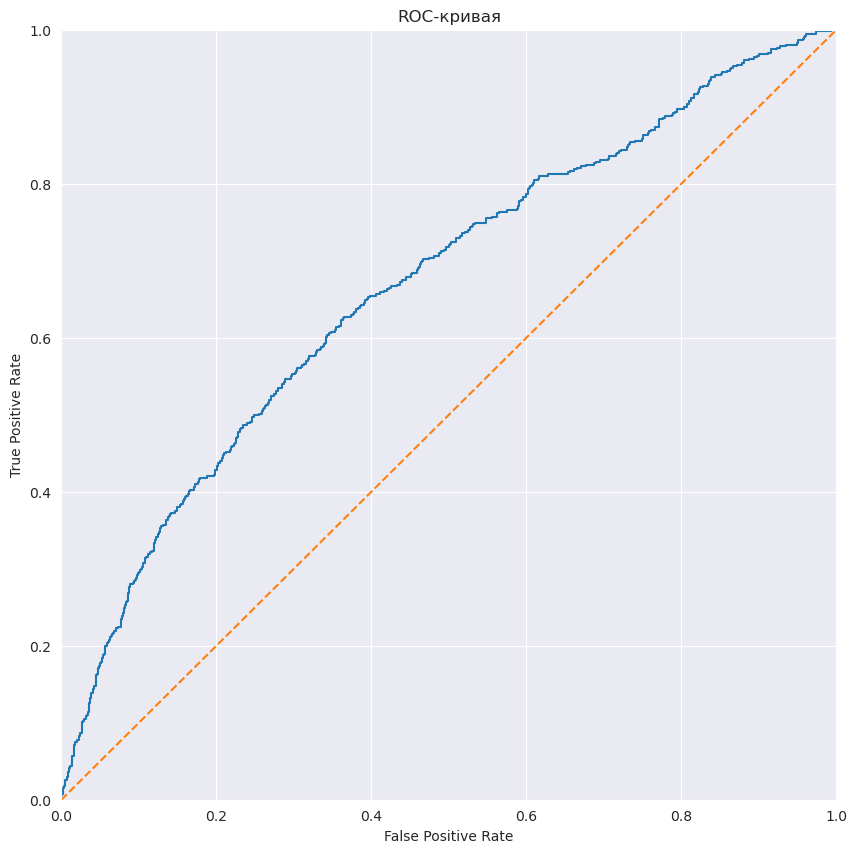

AUC: 0.6673920853163587
Accuracy 0.7248


In [78]:
fpr, tpr, thresholds = roc_curve(y_test_clean, y_pred)
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.show()

print('AUC:', roc_auc_score(y_test_clean, y_pred))
print('Accuracy', accuracy_score(y_test_clean, y_bin))

Достаточно низкий результат. Работать с этой моделью не будем - перейдем к градиентному бустингу

## Catboost градиентный бустинг

### Catboost градиентный бустинг базовый

In [79]:
X_train_cat = X_train.pipe(fill_nan)
X_test_cat = X_test.pipe(fill_nan)

In [80]:
cat_features = list(X_train_cat.select_dtypes(include=['object', 'category']).columns)
num_features = list(X_train_cat.select_dtypes(exclude=['object', 'category']).columns)

In [81]:
X, X_val, y, y_val = train_test_split(X_train_cat, y_train, 
                                      stratify=y_train, random_state=42)

In [82]:
train_data = Pool(data=X, 
                  label=y,
                  cat_features=cat_features)
valid_data = Pool(data=X_val, 
                  label=y_val,
                  cat_features=cat_features)

params = {'loss_function':'Logloss',
          'eval_metric':'AUC',
          'verbose': 200,
          'random_seed': 42,
          'auto_class_weights': 'SqrtBalanced'
         }

model = CatBoostClassifier(**params)
model.fit(train_data,
          eval_set=valid_data, 
          use_best_model=True
          )


Learning rate set to 0.04855
0:	test: 0.7213825	best: 0.7213825 (0)	total: 57.2ms	remaining: 57.1s
200:	test: 0.7612314	best: 0.7622155 (125)	total: 1.01s	remaining: 4s
400:	test: 0.7487302	best: 0.7622155 (125)	total: 2.03s	remaining: 3.03s
600:	test: 0.7425261	best: 0.7622155 (125)	total: 3.03s	remaining: 2.01s
800:	test: 0.7374285	best: 0.7622155 (125)	total: 4.05s	remaining: 1.01s
999:	test: 0.7341183	best: 0.7622155 (125)	total: 5.07s	remaining: 0us

bestTest = 0.7622154952
bestIteration = 125

Shrink model to first 126 iterations.


In [83]:
y_pred = model.predict_proba(X_test_cat)[:, 1]

auc.append(roc_auc_score(y_test, y_pred, average ='macro'))
y_bin = (y_pred >= 0.5)*1
accuracy.append(accuracy_score(y_test, y_bin))
model_name.append((str(model.__class__.__name__)+str(' ')+str('базовый')))

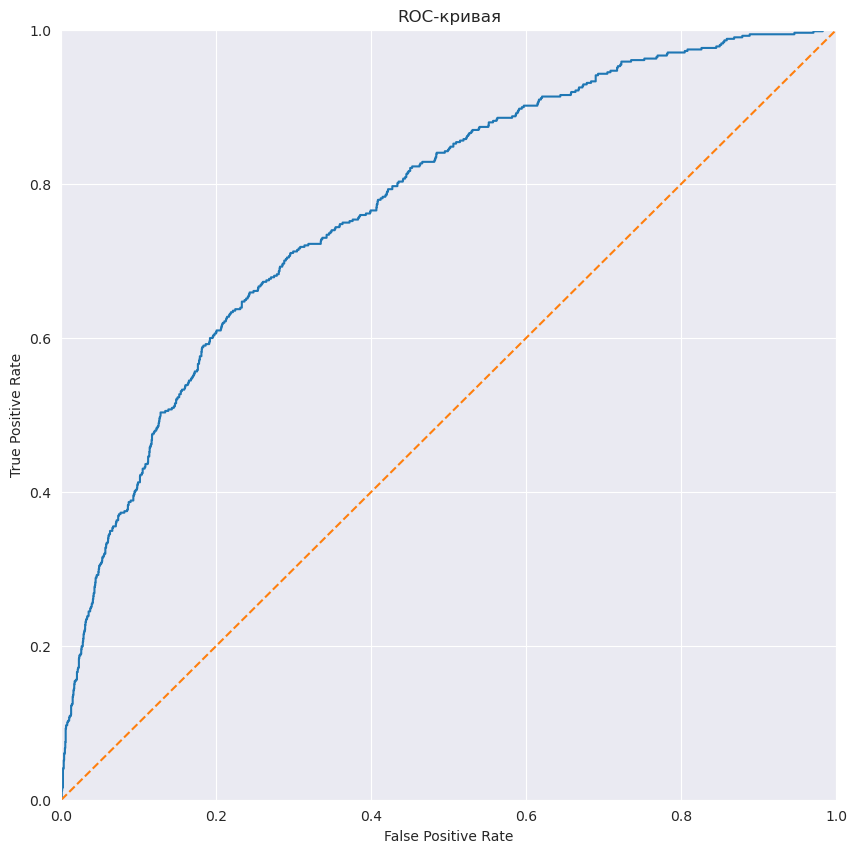

AUC: 0.7735813018147343


In [84]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.show()


print("AUC:", roc_auc_score(y_test, y_pred, average ='macro'))

Получили результат, лучше чем у линейной модели, но не достаточно хороший. 

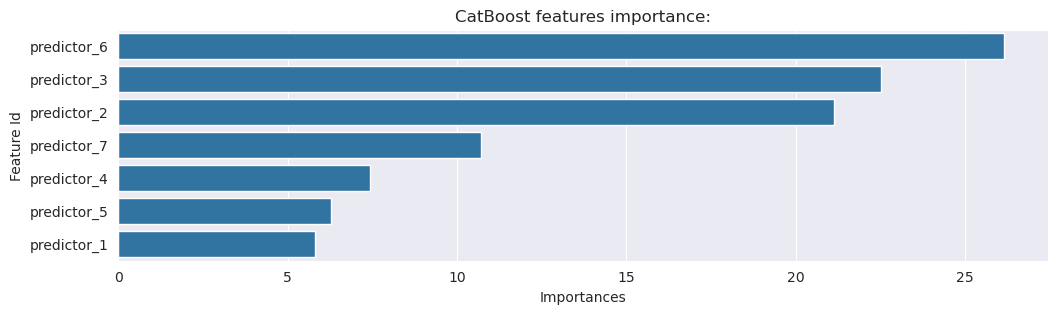

In [85]:
fi = model.get_feature_importance(prettified=True)

plt.figure(figsize=(12, 3));
sns.barplot(x="Importances", y="Feature Id", data=fi);
plt.title('CatBoost features importance:');

Признак 2 пересекается с оценкой на взаимную информацию. Его точно будем оставлять при отборе. Как и признак 3. Попробуем применить кросс-валидацию и сделать ансамблевое предсказание, усреднив общую оценку

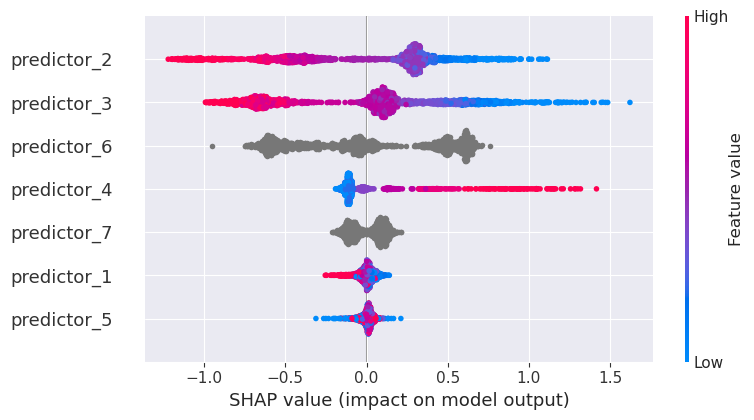

In [86]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val)
shap.summary_plot(shap_values, X_val)

Learning rate set to 0.04855
0:	test: 0.7213825	best: 0.7213825 (0)	total: 7ms	remaining: 6.99s
200:	test: 0.7612314	best: 0.7622155 (125)	total: 1.05s	remaining: 4.18s
400:	test: 0.7487302	best: 0.7622155 (125)	total: 2.11s	remaining: 3.15s
600:	test: 0.7425261	best: 0.7622155 (125)	total: 3.15s	remaining: 2.09s
800:	test: 0.7374285	best: 0.7622155 (125)	total: 4.24s	remaining: 1.05s
999:	test: 0.7341183	best: 0.7622155 (125)	total: 5.25s	remaining: 0us

bestTest = 0.7622154952
bestIteration = 125

Shrink model to first 126 iterations.
Порог = 0.00 | Точность = 0.203, Полнота = 1.000 | F1-мера = 0.337
Порог = 0.05 | Точность = 0.209, Полнота = 0.996 | F1-мера = 0.345
Порог = 0.10 | Точность = 0.232, Полнота = 0.974 | F1-мера = 0.374
Порог = 0.15 | Точность = 0.262, Полнота = 0.919 | F1-мера = 0.407
Порог = 0.20 | Точность = 0.295, Полнота = 0.858 | F1-мера = 0.439
Порог = 0.25 | Точность = 0.319, Полнота = 0.799 | F1-мера = 0.456
Порог = 0.30 | Точность = 0.365, Полнота = 0.722 | F1-м

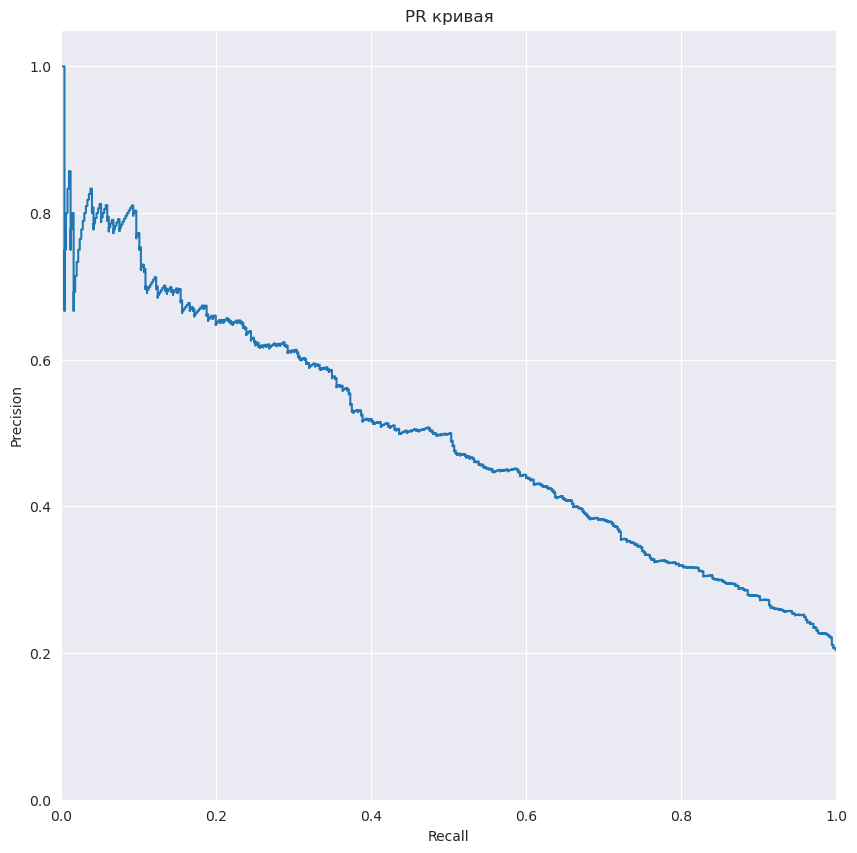

In [87]:
model.fit(train_data,
          eval_set=valid_data, 
          use_best_model=True
          )
probabilities_valid = model.predict_proba(X_test_cat)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 0.95, 0.05):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(y_test, predicted_valid)
    recall = recall_score(y_test, predicted_valid)
    f1 = f1_score(y_test, predicted_valid)
    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f} | F1-мера = {:.3f}".format(
        threshold, precision, recall, f1))

precision, recall, thresholds = precision_recall_curve(y_test, probabilities_valid[:, 1])    
plt.figure(figsize=(10, 10))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('PR кривая')
plt.show() 

Для порога 0 полнота равна 1 - все ответы положительные. При пороге `0.85` модель перестает давать правильные ответы. Самый высокий показатель `F1` наблюдаем с порогом `0.35-0.40`. В дальнейшем будем смотреть на `ROC-AUC` кривую и `AUC` - уточнений о важности классов не поступало. 

### Catboost градиентный бустинг кросс-валидация

In [88]:
n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)

params_cat = {'loss_function':'Logloss',
          'eval_metric':'AUC',
          'verbose': 200,
          'random_seed': 42,
          'auto_class_weights': 'SqrtBalanced'
         }

test_data = Pool(data=X_test_cat,
                 cat_features=cat_features)
scores = []
prediction = np.zeros(X_test_cat.shape[0])
for fold_n, (train_index, valid_index) in enumerate(folds.split(X_train_cat, y_train)):
    X_train_c, X_valid_cat = X_train_cat.iloc[train_index], X_train_cat.iloc[valid_index]
    y_train_cat, y_valid_cat = y_train.iloc[train_index], y_train.iloc[valid_index]
    
    train_data = Pool(data=X_train_c, 
                      label=y_train_cat,
                      cat_features=cat_features)
    valid_data = Pool(data=X_valid_cat, 
                      label=y_valid_cat,
                      cat_features=cat_features)
    
    model = CatBoostClassifier(**params_cat)
    model.fit(train_data,
              eval_set=valid_data, 
              use_best_model=True
             )
    score = model.get_best_score()['validation']['AUC']
    scores.append(score)

    y_pred = model.predict_proba(test_data)[:, 1]
    prediction += y_pred

prediction /= n_fold


Learning rate set to 0.04933
0:	test: 0.7256669	best: 0.7256669 (0)	total: 6.26ms	remaining: 6.26s
200:	test: 0.7746338	best: 0.7767769 (125)	total: 954ms	remaining: 3.79s
400:	test: 0.7652209	best: 0.7767769 (125)	total: 1.95s	remaining: 2.92s
600:	test: 0.7594756	best: 0.7767769 (125)	total: 2.97s	remaining: 1.97s
800:	test: 0.7533058	best: 0.7767769 (125)	total: 4.01s	remaining: 996ms
999:	test: 0.7504959	best: 0.7767769 (125)	total: 5.04s	remaining: 0us

bestTest = 0.7767768595
bestIteration = 125

Shrink model to first 126 iterations.
Learning rate set to 0.04933
0:	test: 0.7286777	best: 0.7286777 (0)	total: 4.95ms	remaining: 4.95s
200:	test: 0.7702850	best: 0.7706298 (197)	total: 988ms	remaining: 3.93s
400:	test: 0.7630892	best: 0.7711057 (254)	total: 2.08s	remaining: 3.1s
600:	test: 0.7602508	best: 0.7711057 (254)	total: 3.15s	remaining: 2.1s
800:	test: 0.7546737	best: 0.7711057 (254)	total: 4.2s	remaining: 1.04s
999:	test: 0.7510060	best: 0.7711057 (254)	total: 5.39s	remaining:

In [89]:
auc.append(roc_auc_score(y_test, prediction, average ='macro'))
y_bin = (prediction >= 0.5)*1
accuracy.append(accuracy_score(y_test, y_bin))
model_name.append((str(model.__class__.__name__)+str(' ')+str('CV')))

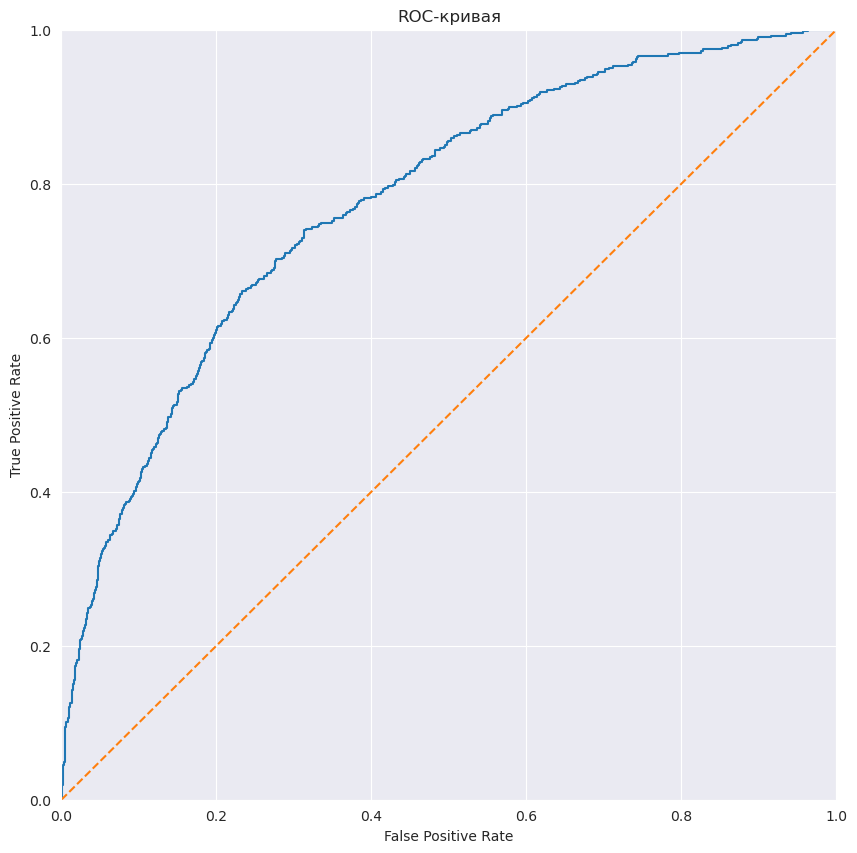

AUC: 0.7769916601596714


In [90]:
fpr, tpr, thresholds = roc_curve(y_test, prediction) 

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.show()

print("AUC:", roc_auc_score(y_test, prediction, average ='macro'))

Результат чуть лучше - попробуем настройку параметров, затем повторим кросс-валидацию

In [91]:
def objective(trial, data=X_train_cat, target=y_train):
    
    X, X_v, y, y_v = train_test_split(X_train_cat, y_train, stratify=y_train, random_state=42)

    params_cat = {

        
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.1, 1),
        'objective': 'Logloss',
        'depth': trial.suggest_int('depth', 2, 9),
        'boosting_type': 'Ordered',
        'bootstrap_type': 'MVS',
        'auto_class_weights': 'SqrtBalanced',
        'boost_from_average': True,
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 1, 5),

    }

    train_data = Pool(data=X, 
                  label=y,
                  cat_features=cat_features)
    valid_data = Pool(data=X_v, 
                      label=y_v,
                      cat_features=cat_features)

    model = CatBoostClassifier(**params_cat, random_seed=42, verbose=False)
    model.fit(train_data,
              eval_set=valid_data, use_best_model=True
             )
    preds = model.predict_proba(X_v)[:, 1]
    auc = roc_auc_score(y_v, preds, average ='macro')
    return auc


In [92]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, timeout=1200)
print('Количество завершенных испытаний/max trials:', len(study.trials))
print('Лучшее испытание/Best trial:', study.best_trial.params)

[I 2023-11-30 15:49:17,611] A new study created in memory with name: no-name-8967ea79-9bdb-4262-a30a-41592d349762
[I 2023-11-30 15:49:22,586] Trial 0 finished with value: 0.7696373601895906 and parameters: {'colsample_bylevel': 0.5453082384456841, 'depth': 4, 'l2_leaf_reg': 2}. Best is trial 0 with value: 0.7696373601895906.
[I 2023-11-30 15:49:26,857] Trial 1 finished with value: 0.7574081715372846 and parameters: {'colsample_bylevel': 0.5801775473965115, 'depth': 2, 'l2_leaf_reg': 3}. Best is trial 0 with value: 0.7696373601895906.
[I 2023-11-30 15:49:32,900] Trial 2 finished with value: 0.7698984491679843 and parameters: {'colsample_bylevel': 0.6064675391531454, 'depth': 5, 'l2_leaf_reg': 1}. Best is trial 2 with value: 0.7698984491679843.
[I 2023-11-30 15:49:47,696] Trial 3 finished with value: 0.7684040342811654 and parameters: {'colsample_bylevel': 0.6815425340042565, 'depth': 8, 'l2_leaf_reg': 2}. Best is trial 2 with value: 0.7698984491679843.
[I 2023-11-30 15:49:51,741] Trial 

Количество завершенных испытаний/max trials: 50
Лучшее испытание/Best trial: {'colsample_bylevel': 0.47173512453952504, 'depth': 5, 'l2_leaf_reg': 2}


In [93]:
n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)

params_cat = {

    
    'colsample_bylevel': 0.366724690212295,
    'depth': 4,
    'boosting_type': 'Ordered',
    'bootstrap_type': 'MVS',
    'auto_class_weights': 'SqrtBalanced',
    'boost_from_average': True,
    'l2_leaf_reg': 4,
    'loss_function':'Logloss',
    'eval_metric':'AUC',
    'verbose': 200,
}

test_data = Pool(data=X_test_cat,
                 cat_features=cat_features)
scores = []
prediction = np.zeros(X_test_cat.shape[0])
for fold_n, (train_index, valid_index) in enumerate(folds.split(X_train_cat, y_train)):
    X_train_c, X_valid_cat = X_train_cat.iloc[train_index], X_train_cat.iloc[valid_index]
    y_train_cat, y_valid_cat = y_train.iloc[train_index], y_train.iloc[valid_index]
    
    train_data = Pool(data=X_train_c, 
                      label=y_train_cat,
                      cat_features=cat_features)
    valid_data = Pool(data=X_valid_cat, 
                      label=y_valid_cat,
                      cat_features=cat_features)
    
    model = CatBoostClassifier(**params_cat)
    model.fit(train_data,
              eval_set=valid_data, 
              use_best_model=True
             )
    score = model.get_best_score()['validation']['AUC']
    scores.append(score)

    y_pred = model.predict_proba(test_data)[:, 1]
    prediction += y_pred

prediction /= n_fold

0:	test: 0.7102722	best: 0.7102722 (0)	total: 7.76ms	remaining: 7.76s
200:	test: 0.7740353	best: 0.7740353 (200)	total: 1.55s	remaining: 6.16s
400:	test: 0.7774608	best: 0.7774608 (400)	total: 2.95s	remaining: 4.4s
600:	test: 0.7782445	best: 0.7788800 (542)	total: 4.24s	remaining: 2.82s
800:	test: 0.7794300	best: 0.7796666 (764)	total: 5.55s	remaining: 1.38s
999:	test: 0.7797093	best: 0.7801425 (895)	total: 6.73s	remaining: 0us

bestTest = 0.7801424907
bestIteration = 895

Shrink model to first 896 iterations.
0:	test: 0.6838045	best: 0.6838045 (0)	total: 4.62ms	remaining: 4.61s
200:	test: 0.7585437	best: 0.7585437 (200)	total: 1.1s	remaining: 4.39s
400:	test: 0.7661300	best: 0.7661357 (399)	total: 2.23s	remaining: 3.33s
600:	test: 0.7650499	best: 0.7666629 (452)	total: 3.39s	remaining: 2.25s
800:	test: 0.7637874	best: 0.7666629 (452)	total: 4.57s	remaining: 1.14s
999:	test: 0.7631490	best: 0.7666629 (452)	total: 5.72s	remaining: 0us

bestTest = 0.7666628669
bestIteration = 452

Shrink

In [94]:
auc.append(roc_auc_score(y_test, prediction, average ='macro'))
y_bin = (prediction >= 0.5)*1
accuracy.append(accuracy_score(y_test, y_bin))
model_name.append((str(model.__class__.__name__)+str(' ')+str('CV_tuned')))

print(confusion_matrix(y_test, y_bin))

[[1787  206]
 [ 288  219]]


Ошибка второго рода допущена 206 раз, достаточно много или мало - необходимо ориентироваться на существующую систему оценки дефолта

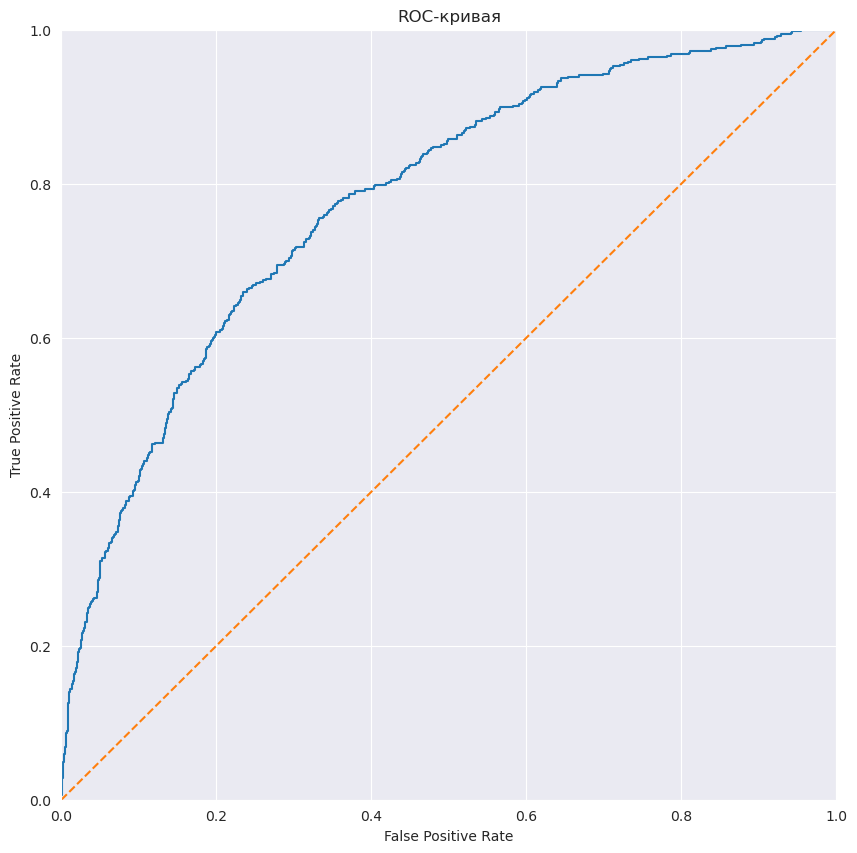

AUC: 0.7788373706394472


In [95]:
fpr, tpr, thresholds = roc_curve(y_test, prediction) 

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.show()

print("AUC:", roc_auc_score(y_test, prediction, average ='macro'))

Улучшили результат. Но необходимы изменения признаков дополнительные и их отбор - результат неудовлетворительный

### Catboost SMOTE

Попробуем технику SMOTE

In [96]:
params_cat = {

    
    'colsample_bylevel': 0.366724690212295,
    'depth': 4,
    'boosting_type': 'Ordered',
    'bootstrap_type': 'MVS',
    'boost_from_average': True,
    'l2_leaf_reg': 4,
    'loss_function':'Logloss',
    'eval_metric':'AUC',
    'verbose': 200,
    'iterations': 2000
}

In [97]:
print('Соотношение классов в обучающей выборке %s' % Counter(y_train))

Соотношение классов в обучающей выборке Counter({0: 6052, 1: 1448})


In [98]:
sm = SMOTE(random_state=42)

X_over, y_over = sm.fit_resample(X_train_prep_clean, y_train_clean)
print('Соотношение классов в SMOTE выборке %s' % Counter(y_over))

Соотношение классов в SMOTE выборке Counter({1: 6052, 0: 6052})


In [99]:
X_res, X_val_, y_res, y_val_ = train_test_split(X_over, y_over, 
                                      test_size=.25, random_state=42)

In [100]:
train_data = Pool(data=X_res, 
                  label=y_res)
valid_data = Pool(data=X_val_, 
                  label=y_val_)


model = CatBoostClassifier(**params_cat)
model.fit(train_data,
          eval_set=valid_data, 
          use_best_model=True
          )


0:	test: 0.7867631	best: 0.7867631 (0)	total: 8.76ms	remaining: 17.5s
200:	test: 0.9281246	best: 0.9281273 (199)	total: 2.12s	remaining: 19s
400:	test: 0.9372879	best: 0.9373290 (399)	total: 4.26s	remaining: 17s
600:	test: 0.9400129	best: 0.9400238 (596)	total: 6.35s	remaining: 14.8s
800:	test: 0.9407210	best: 0.9408023 (771)	total: 8.42s	remaining: 12.6s
1000:	test: 0.9412138	best: 0.9412767 (975)	total: 10.4s	remaining: 10.4s
1200:	test: 0.9417066	best: 0.9417066 (1200)	total: 12.5s	remaining: 8.29s
1400:	test: 0.9414541	best: 0.9417245 (1227)	total: 14.5s	remaining: 6.2s
1600:	test: 0.9412134	best: 0.9417245 (1227)	total: 16.5s	remaining: 4.11s
1800:	test: 0.9413169	best: 0.9417245 (1227)	total: 18.5s	remaining: 2.05s
1999:	test: 0.9415105	best: 0.9417245 (1227)	total: 20.5s	remaining: 0us

bestTest = 0.9417245334
bestIteration = 1227

Shrink model to first 1228 iterations.


In [101]:
y_preds = model.predict_proba(X_test_prep_clean)[:,1]

In [102]:
auc.append(roc_auc_score(y_test, y_preds, average ='macro'))
y_bin = (prediction >= 0.5)*1
accuracy.append(accuracy_score(y_test, y_bin))
model_name.append((str(model.__class__.__name__)+str(' ')+str('CV_SMOTE')))

print(confusion_matrix(y_test, y_bin))

[[1787  206]
 [ 288  219]]


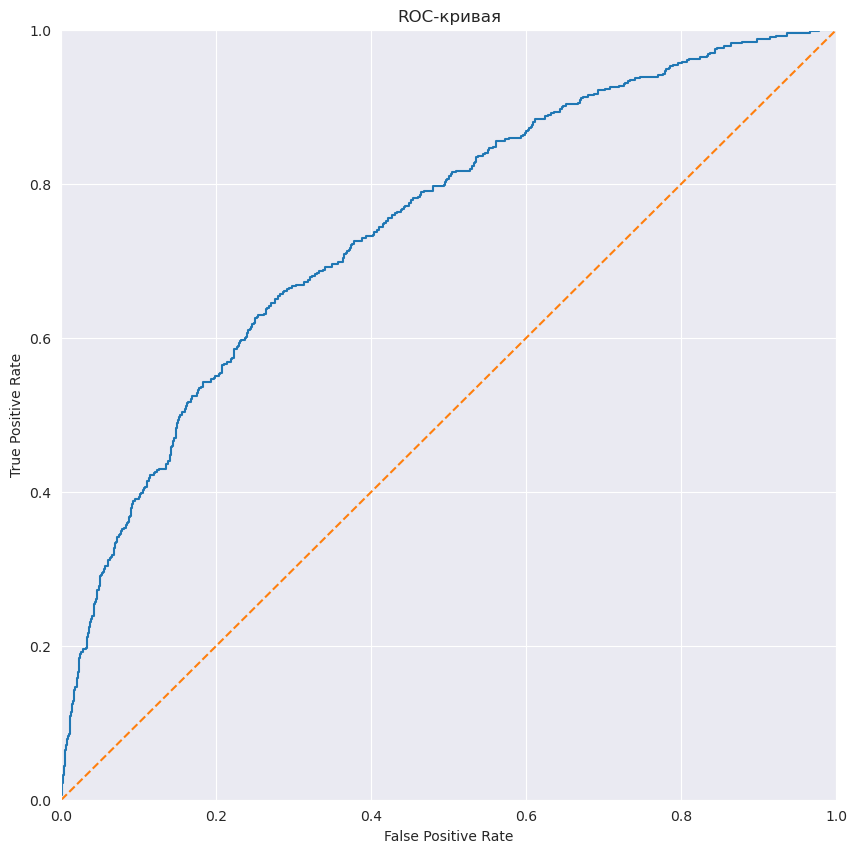

AUC: 0.7463023936836126


In [103]:
fpr, tpr, thresholds = roc_curve(y_test, y_preds) 

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.show()

print("AUC:", roc_auc_score(y_test, y_preds, average ='macro'))

Результат не улучшили - стал хуже

### Catboost градиентный бустинг отбор признаков

Попробуем отобрать признаки с помощью shap feature importance

In [104]:
vals = np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(X_val.columns, vals)),columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)

feature_importance.head()

,col_name,feature_importance_vals
1,predictor_2,0.437624
2,predictor_3,0.427497
5,predictor_6,0.404121
3,predictor_4,0.158818
6,predictor_7,0.093261


Основываясь на взаимной информации и важности признаков - обучим модель на признаках 2-4

In [105]:
X_train_cat.head()

,predictor_1,predictor_2,predictor_3,predictor_4,predictor_5,predictor_6,predictor_7
4901,4936,762,135.0,9,3872.0,D2,B2
4375,22106,1140,326.5,1,1602.5,D_unknown,B2
6698,42723,1106,377.5,1,1858.0,D3,B1
9805,20322,1336,377.5,1,351.0,D_unknown,B1
1101,13638,1082,329.5,5,2614.5,D4,B2


In [106]:
X_train_selected = X_train_cat.iloc[:, list(feature_importance.index)[:3]]
X_test_selected = X_test_cat.iloc[:, list(feature_importance.index)[:3]]

In [107]:
cat_features = list(X_train_selected.select_dtypes(include=['object', 'category']).columns)
num_features = list(X_train_selected.select_dtypes(exclude=['object', 'category']).columns)

In [108]:
X, X_val, y, y_val = train_test_split(X_train_selected, y_train, 
                                      test_size=0.25, random_state=42)

In [109]:
train_data = Pool(data=X, 
                  label=y,
                  cat_features=cat_features)
valid_data = Pool(data=X_val, 
                  label=y_val,
                  cat_features=cat_features)

params_cat = {

    
    'colsample_bylevel': 0.6853097892753522,
    'depth': 4,
    'boosting_type': 'Ordered',
    'bootstrap_type': 'MVS',
    'auto_class_weights': 'SqrtBalanced',
    'boost_from_average': True,
    'l2_leaf_reg': 4,
    'learning_rate':0.16816066017131695,
    'loss_function':'Logloss',
    'eval_metric':'AUC',
    'verbose': 200,
}

model = CatBoostClassifier(**params)
model.fit(train_data,
          eval_set=valid_data, 
          use_best_model=True
          )


Learning rate set to 0.04855
0:	test: 0.7067442	best: 0.7067442 (0)	total: 6.53ms	remaining: 6.53s
200:	test: 0.7317502	best: 0.7352109 (73)	total: 938ms	remaining: 3.73s
400:	test: 0.7276642	best: 0.7352109 (73)	total: 2.01s	remaining: 3s
600:	test: 0.7250454	best: 0.7352109 (73)	total: 3.09s	remaining: 2.05s
800:	test: 0.7198443	best: 0.7352109 (73)	total: 4.16s	remaining: 1.03s
999:	test: 0.7178837	best: 0.7352109 (73)	total: 5.23s	remaining: 0us

bestTest = 0.7352108853
bestIteration = 73

Shrink model to first 74 iterations.


In [110]:
y_pred = model.predict_proba(X_test_selected)[:, 1]

auc.append(roc_auc_score(y_test, y_pred, average ='macro'))
y_bin = (y_pred >= 0.5)*1
accuracy.append(accuracy_score(y_test, y_bin))
model_name.append((str(model.__class__.__name__)+str(' ')+str('признаки')))

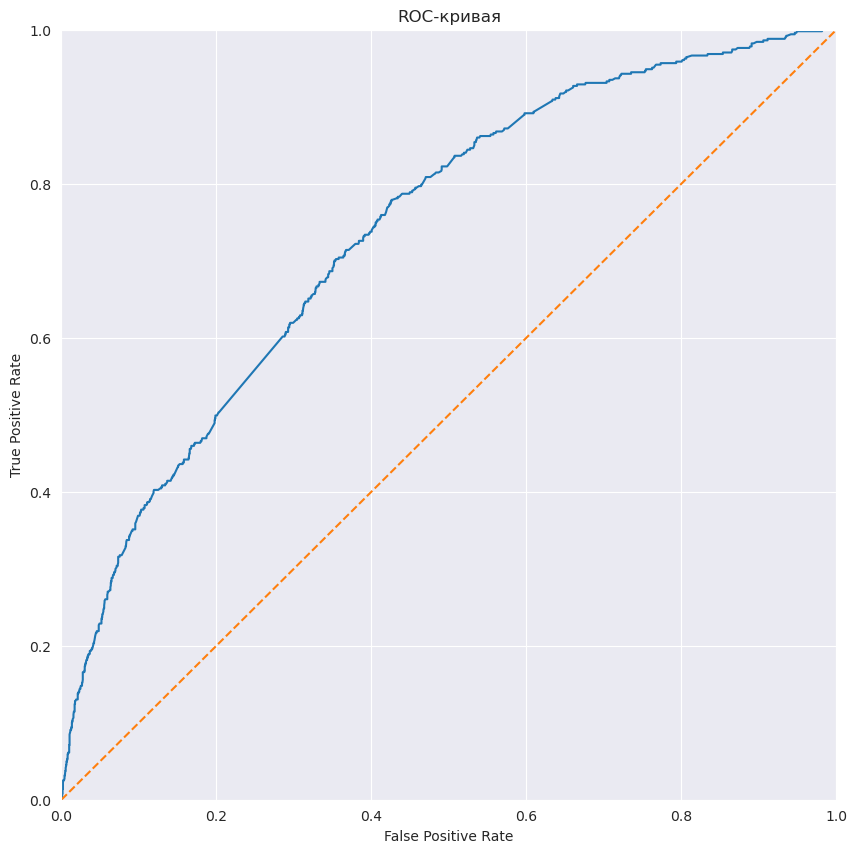

AUC: 0.7376394303137906


In [111]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.show()


print("AUC:", roc_auc_score(y_test, y_pred, average ='macro'))

Результат стах хуже, но при этом не так значительно, с учетом того, что мы используем только 3 признака из 7. Попробуем настроить модель и использовать кросс-валидацию

In [112]:
def objective(trial, data=X_train_cat, target=y_train):
    
    X, X_v, y, y_v = train_test_split(X_train_selected, y_train, stratify=y_train, random_state=42)

    params_cat = {

        
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.1, 1),
        'objective': 'Logloss',
        'depth': trial.suggest_int('depth', 2, 9),
        'boosting_type': 'Ordered',
        'bootstrap_type': 'MVS',
        'auto_class_weights': 'SqrtBalanced',
        'boost_from_average': True,
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 1, 5),

    }

    train_data = Pool(data=X, 
                  label=y,
                  cat_features=cat_features)
    valid_data = Pool(data=X_v, 
                      label=y_v,
                      cat_features=cat_features)

    model = CatBoostClassifier(**params_cat, random_seed=42, verbose=False)
    model.fit(train_data,
              eval_set=valid_data, use_best_model=True
             )
    preds = model.predict_proba(X_v)[:, 1]
    auc = roc_auc_score(y_v, preds, average ='macro')
    return auc


In [113]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, timeout=1200)
print('Количество завершенных испытаний/max trials:', len(study.trials))
print('Лучшее испытание/Best trial:', study.best_trial.params)

[I 2023-11-30 15:56:19,645] A new study created in memory with name: no-name-2ad39f87-575b-42e4-ae28-7d9936d112ce
[I 2023-11-30 15:56:23,915] Trial 0 finished with value: 0.7359806173384991 and parameters: {'colsample_bylevel': 0.3872883815919391, 'depth': 2, 'l2_leaf_reg': 2}. Best is trial 0 with value: 0.7359806173384991.
[I 2023-11-30 15:56:35,572] Trial 1 finished with value: 0.7357779538657601 and parameters: {'colsample_bylevel': 0.9951578136460777, 'depth': 8, 'l2_leaf_reg': 2}. Best is trial 0 with value: 0.7359806173384991.
[I 2023-11-30 15:56:45,516] Trial 2 finished with value: 0.7333806823368741 and parameters: {'colsample_bylevel': 0.6730355187499306, 'depth': 8, 'l2_leaf_reg': 5}. Best is trial 0 with value: 0.7359806173384991.
[I 2023-11-30 15:56:52,565] Trial 3 finished with value: 0.7349399130190285 and parameters: {'colsample_bylevel': 0.5116295524204137, 'depth': 7, 'l2_leaf_reg': 3}. Best is trial 0 with value: 0.7359806173384991.
[I 2023-11-30 15:57:02,632] Trial 

Количество завершенных испытаний/max trials: 50
Лучшее испытание/Best trial: {'colsample_bylevel': 0.144211247290835, 'depth': 3, 'l2_leaf_reg': 4}


In [114]:
n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)

params_cat = {

    
    'colsample_bylevel': 0.10412325828483976,
    'depth': 6,
    'boosting_type': 'Ordered',
    'bootstrap_type': 'MVS',
    'auto_class_weights': 'SqrtBalanced',
    'boost_from_average': True,
    'l2_leaf_reg': 4,
    'loss_function':'Logloss',
    'eval_metric':'AUC',
    'verbose': 200,
}

test_data = Pool(data=X_test_selected,
                 cat_features=cat_features)
scores = []
prediction = np.zeros(X_test_selected.shape[0])
for fold_n, (train_index, valid_index) in enumerate(folds.split(X_train_selected, y_train)):
    X_train_c, X_valid_cat = X_train_selected.iloc[train_index], X_train_selected.iloc[valid_index]
    y_train_cat, y_valid_cat = y_train.iloc[train_index], y_train.iloc[valid_index]
    
    train_data = Pool(data=X_train_c, 
                      label=y_train_cat,
                      cat_features=cat_features)
    valid_data = Pool(data=X_valid_cat, 
                      label=y_valid_cat,
                      cat_features=cat_features)
    
    model = CatBoostClassifier(**params_cat)
    model.fit(train_data,
              eval_set=valid_data, 
              use_best_model=True
             )
    score = model.get_best_score()['validation']['AUC']
    scores.append(score)

    y_pred = model.predict_proba(test_data)[:, 1]
    prediction += y_pred

prediction /= n_fold

0:	test: 0.6782089	best: 0.6782089 (0)	total: 5.03ms	remaining: 5.02s
200:	test: 0.7490154	best: 0.7502636 (128)	total: 751ms	remaining: 2.98s
400:	test: 0.7498803	best: 0.7502636 (128)	total: 1.49s	remaining: 2.22s
600:	test: 0.7510601	best: 0.7522357 (510)	total: 2.22s	remaining: 1.47s
800:	test: 0.7518837	best: 0.7522357 (510)	total: 2.96s	remaining: 735ms
999:	test: 0.7520433	best: 0.7522357 (510)	total: 3.68s	remaining: 0us

bestTest = 0.7522356797
bestIteration = 510

Shrink model to first 511 iterations.
0:	test: 0.6525278	best: 0.6525278 (0)	total: 4.07ms	remaining: 4.06s
200:	test: 0.7358578	best: 0.7365232 (191)	total: 717ms	remaining: 2.85s
400:	test: 0.7378769	best: 0.7387276 (380)	total: 1.46s	remaining: 2.18s
600:	test: 0.7386948	best: 0.7390282 (584)	total: 2.2s	remaining: 1.46s
800:	test: 0.7399630	best: 0.7399630 (796)	total: 2.94s	remaining: 730ms
999:	test: 0.7402308	best: 0.7403876 (977)	total: 3.65s	remaining: 0us

bestTest = 0.7403875748
bestIteration = 977

Shrin

In [115]:
auc.append(roc_auc_score(y_test, prediction, average ='macro'))
y_bin = (prediction >= 0.5)*1
accuracy.append(accuracy_score(y_test, y_bin))
model_name.append((str(model.__class__.__name__)+str(' ')+str('optuna_tuned_selected')))

print(confusion_matrix(y_test, y_bin))

[[1805  188]
 [ 332  175]]


Здесь чаще получаем FP

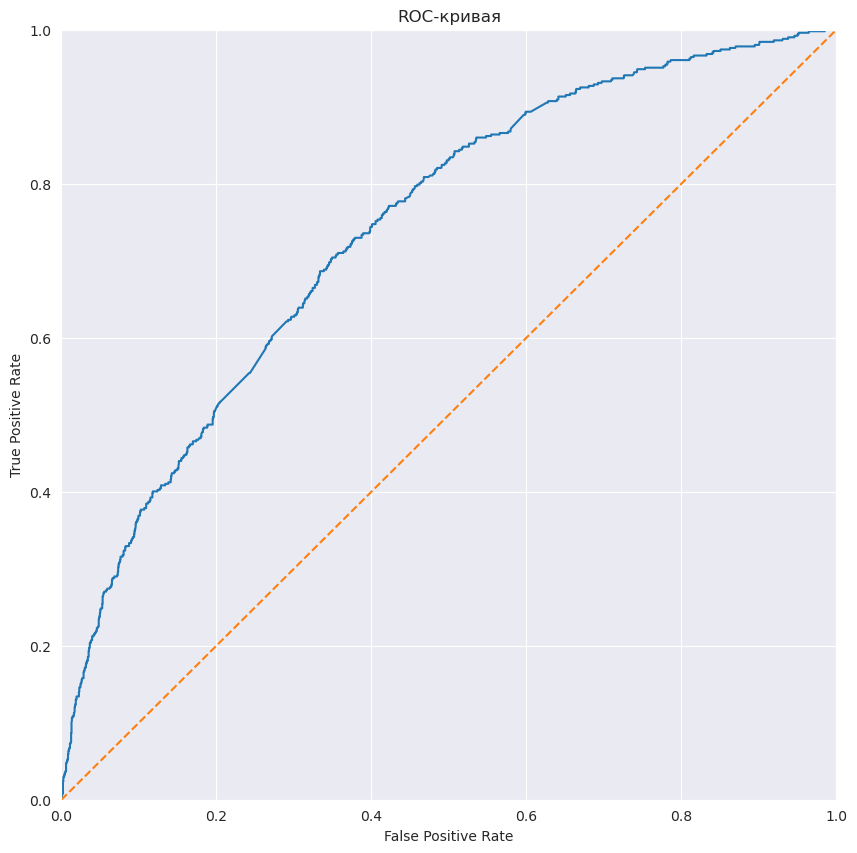

AUC: 0.7394673269658796


In [116]:
fpr, tpr, thresholds = roc_curve(y_test, prediction) 

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.show()

print("AUC:", roc_auc_score(y_test, prediction, average ='macro'))

In [117]:
summary = pd.DataFrame({ 
    'model' : model_name , 
    'AUC' : auc,
    'Accuracy': accuracy}
    ).sort_values(by='AUC', ascending=False).reset_index(drop=True)
try:
  report = summary.iloc[[0, 1, 3, 4, 7, 8, 9, 10, 11]].reset_index(drop=True)
except:
  summary.style.highlight_max( 'AUC' , color = 'green' , axis = 0 )

In [118]:
report

<module 'phik.report' from '/home/antonius/.local/lib/python3.10/site-packages/phik/report.py'>

Лучше всего показал себя `Catboost` с настройкой на `Optuna` и предсказаниями с кросс-валидацией

<a href="#footer"> Наверх </a>
<footer id="footer"></footer>

___


### Класс на отбор признаков

В `sklearn` присутствует класс [RFE](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html) - Во-первых, оценщик обучается на начальном наборе функций, и важность каждой функции определяется либо через какой-либо конкретный атрибут, либо через вызываемый. Затем наименее важные функции удаляются из текущего набора функций. Эта процедура рекурсивно повторяется для сокращенного набора до тех пор, пока в конечном итоге не будет достигнуто желаемое количество функций для выбора.  


Его будем использовать как реперную точку - для проверки качества нашего отборщика. Напомню, что отобрав признаки через `shap` - мы получили `AUC 0.73`

In [119]:
params_cat = {

    'auto_class_weights': 'SqrtBalanced',
    'loss_function':'Logloss',
    'eval_metric':'AUC',
    'verbose': 200
}


estimator = CatBoostClassifier(**params_cat)
selector = RFE(estimator, n_features_to_select=3, step=1)
selector = selector.fit(X_train_prep, y_train)


Learning rate set to 0.024355
0:	total: 4.37ms	remaining: 4.37s
200:	total: 583ms	remaining: 2.32s
400:	total: 1.12s	remaining: 1.68s
600:	total: 1.67s	remaining: 1.1s
800:	total: 2.21s	remaining: 549ms
999:	total: 2.75s	remaining: 0us
Learning rate set to 0.024355
0:	total: 2.56ms	remaining: 2.56s
200:	total: 539ms	remaining: 2.14s
400:	total: 1.06s	remaining: 1.59s
600:	total: 1.6s	remaining: 1.06s
800:	total: 2.14s	remaining: 531ms
999:	total: 2.68s	remaining: 0us
Learning rate set to 0.024355
0:	total: 2.53ms	remaining: 2.53s
200:	total: 535ms	remaining: 2.13s
400:	total: 1.08s	remaining: 1.61s
600:	total: 1.81s	remaining: 1.2s
800:	total: 2.34s	remaining: 583ms
999:	total: 2.88s	remaining: 0us
Learning rate set to 0.024355
0:	total: 2.57ms	remaining: 2.57s
200:	total: 520ms	remaining: 2.06s
400:	total: 1.05s	remaining: 1.57s
600:	total: 1.58s	remaining: 1.05s
800:	total: 2.12s	remaining: 527ms
999:	total: 2.65s	remaining: 0us
Learning rate set to 0.024355
0:	total: 2.94ms	remainin

Получим ранги признаков от RFE и посмотрим, что выйдет при обучении модели:

In [120]:
for i in range(X.shape[1]):
	print('Column: %d, Selected %s, Rank: %.3f' % (i, selector.support_[i], selector.ranking_[i]))

Column: 0, Selected True, Rank: 1.000
Column: 1, Selected True, Rank: 1.000
Column: 2, Selected True, Rank: 1.000


In [121]:
estimator = CatBoostClassifier(**params_cat)
estimator.fit(X_train_prep[:, [0,1,2]], y_train)
auc = round(roc_auc_score(y_test, estimator.predict_proba(X_test_prep[:, [0,1,2]])[:,1], average ='macro'), 2)
print(f'AUC на RFE признаках {auc} - auc на признаках, которые отобраны через shap = 0.73')

Learning rate set to 0.024355
0:	total: 3.17ms	remaining: 3.16s
200:	total: 540ms	remaining: 2.15s
400:	total: 1.06s	remaining: 1.58s
600:	total: 1.59s	remaining: 1.06s
800:	total: 2.14s	remaining: 532ms
999:	total: 2.68s	remaining: 0us
AUC на RFE признаках 0.71 - auc на признаках, которые отобраны через shap = 0.73


Напишем свой класс с использованием shap

In [122]:
class ShapFeatureSelection (BaseEstimator, TransformerMixin):
  """
  Класс вычисляет  важность признаков на основе библиотеки Shap. Работает 
  только с деревьями для большей эффективности или моделями на основе 
  градиентного бустинга. Приоритетно использовать такие модели как:
   
   Catboostclassifier, XGboostclassifier

  Для работы необходимо импортировать:

    from sklearn.base import BaseEstimator, TransformerMixin
    import shap

  Параметры
    ----------
    estimator : 
        Обучение с учителем с методом fit позволит получить и отобрать индексы
        самых важных признаков
    n_features_to_select : int, default=None
        Количество признаков для отбора, по умолчанию значение None
    columns: List, default=None
        Список признаков исходного сета, по умолчанию значение None
    
  Методы
    ----------
    fit - обучается и выявляет наиболее важные признаки
    tranform - изменяет исходный сет и вовзращает отобранные признаки
    get_index - возвращает отобранные признаки индексов
    plot_values - построение графика shap values
    _estimator_type - метод @property - возвращает тип модели
    get_feature_importance - возвращает DataFrame FI
  Примечание
    -----
    Не работает с категориальными признаками. Nan/Inf разрешены в случае, если 
    их принимает модель метода fit

    """

  def __init__(self, estimator, n_features_to_select=None, columns=None):
    self.estimator = estimator
    self.n_features_to_select = n_features_to_select
    self.columns = columns

  def fit(self, X, y, **fit_params):
    # разделить выборку на обучение и валидацию
    X_train, self.X_val, y_train, y_val = train_test_split(
                                      X, y, test_size=.25, random_state=42)
    
    assert X_train.shape[0] + self.X_val.shape[0] == X.shape[0], 'Неправильно разделена выборка'
    # обучить модель
    self.estimator.fit(X_train, y_train)

    # получаем предсказание веростности классов
    preds = self.estimator.predict_proba(self.X_val)[:, 1]
    explainer = shap.TreeExplainer(self.estimator)
    self.shap_values = explainer.shap_values(self.X_val)
    # собираем сет данных
    try:
    
      vals = np.abs(self.shap_values).mean(0)
      self.feature_importance = pd.DataFrame(list(zip(self.columns, vals)),columns=['col_name','feature_importance_vals'])
      self.feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
      self.idx = list(self.feature_importance['feature_importance_vals'].index)[:self.n_features_to_select]
      
    except:
      
      vals = np.abs(self.shap_values[:1]).mean(0)
      self.feature_importance = pd.DataFrame(list(zip(self.columns, vals)),columns=['col_name','feature_importance_vals'])
      self.feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
      self.idx = list(self.feature_importance['feature_importance_vals'].index)[:self.n_features_to_select]

    return self

  def transform(self, X, y=None):
    X_selected = X[:, self.idx]
    return X_selected

  def get_index(self):
    return self.idx

  def plot_values(self):
    return shap.summary_plot(self.shap_values, self.X_val)

  @property
  def _estimator_type(self):
    return self.estimator._estimator_type

  def get_feature_importance(self):
    return self.feature_importance


In [123]:
print(ShapFeatureSelection.__doc__)


  Класс вычисляет  важность признаков на основе библиотеки Shap. Работает 
  только с деревьями для большей эффективности или моделями на основе 
  градиентного бустинга. Приоритетно использовать такие модели как:
   
   Catboostclassifier, XGboostclassifier

  Для работы необходимо импортировать:

    from sklearn.base import BaseEstimator, TransformerMixin
    import shap

  Параметры
    ----------
    estimator : 
        Обучение с учителем с методом fit позволит получить и отобрать индексы
        самых важных признаков
    n_features_to_select : int, default=None
        Количество признаков для отбора, по умолчанию значение None
    columns: List, default=None
        Список признаков исходного сета, по умолчанию значение None
    
  Методы
    ----------
    fit - обучается и выявляет наиболее важные признаки
    tranform - изменяет исходный сет и вовзращает отобранные признаки
    get_index - возвращает отобранные признаки индексов
    plot_values - построение графика shap v

In [124]:
cols = list(X_train.columns)

In [125]:
estimator = CatBoostClassifier(**params_cat)
selector = ShapFeatureSelection(estimator, n_features_to_select=3, columns=cols)
X = selector.fit(X_train_prep, y_train)

Learning rate set to 0.02154
0:	total: 2.67ms	remaining: 2.67s
200:	total: 489ms	remaining: 1.94s
400:	total: 955ms	remaining: 1.43s
600:	total: 1.42s	remaining: 945ms
800:	total: 1.89s	remaining: 469ms
999:	total: 2.35s	remaining: 0us


Получим новые сеты. Здесь применен метод tranform - fit применяли выше

In [126]:
X = selector.transform(X_train_prep)
X_t = selector.transform(X_test_prep)

Проверим работу методов:

In [127]:
selector.get_index()

[1, 2, 5]

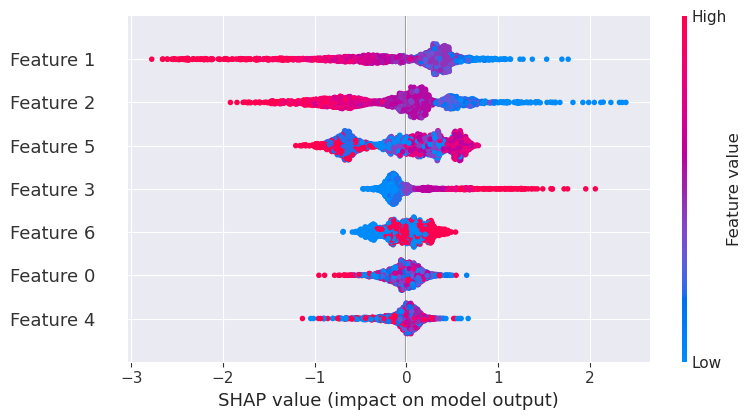

In [128]:
selector.plot_values()

In [129]:
selector._estimator_type

'classifier'

In [130]:
selector.get_feature_importance()

,col_name,feature_importance_vals
1,predictor_2,0.547869
2,predictor_3,0.489630
5,predictor_6,0.417904
3,predictor_4,0.212204
6,predictor_7,0.188270
0,predictor_1,0.125582
4,predictor_5,0.122414


In [131]:
estimator = CatBoostClassifier(**params_cat)
estimator.fit(X, y_train)
auc_self = round(roc_auc_score(y_test, estimator.predict_proba(X_t)[:,1], average ='macro'), 3)
print(f'AUC на RFE признаках {round(auc, 3)} - auc на признаках, которые отобраны через shap {auc_self}')

Learning rate set to 0.024355
0:	total: 3.56ms	remaining: 3.56s
200:	total: 541ms	remaining: 2.15s
400:	total: 1.05s	remaining: 1.57s
600:	total: 1.58s	remaining: 1.05s
800:	total: 2.1s	remaining: 522ms
999:	total: 2.62s	remaining: 0us
AUC на RFE признаках 0.71 - auc на признаках, которые отобраны через shap 0.732


Таким образом получили класс, работающий лучше чем RFE, с использованием библиотеки SHAP, метод `TreeExplainer` - преимущественно лучше использовать с моделями градиентного бустинга - так как они менее склонны к переобучению, чем лес и исправляют большинство ошибок, не накапливая их

Построим пайплайн предобработки с отбором признаков

In [132]:
cat_features = list(X_train_cat.select_dtypes(include=['object', 'category']).columns)
num_features = list(X_train_cat.select_dtypes(exclude=['object', 'category']).columns)

In [133]:
params_cat = {

    'auto_class_weights': 'SqrtBalanced',
    'loss_function':'Logloss',
    'eval_metric':'AUC',
    'verbose': 200
}

cols = list(X_train.columns)
estimator = CatBoostClassifier(**params_cat)
selector = ShapFeatureSelection(estimator, n_features_to_select=3, columns=cols)


preprocessor = ColumnTransformer (
    transformers = [

        ('std_scaler' , StandardScaler() , num_features) ,
        ('cat' , OrdinalEncoder() , cat_features) ,
        ('binary' , OneHotEncoder(drop='first') , binary_features),
        
        
        ]
)

pipe = Pipeline(steps=
    
    [ ('fill_nan', FunctionTransformer(fill_nan, validate=False)),
      ('preprocessor', preprocessor),
      ('selector', selector)

     ]
)


In [134]:
X_selected = pipe.fit_transform(X_train, y_train)

Learning rate set to 0.02154
0:	total: 2.32ms	remaining: 2.31s
200:	total: 472ms	remaining: 1.88s
400:	total: 953ms	remaining: 1.42s
600:	total: 1.42s	remaining: 945ms
800:	total: 1.9s	remaining: 473ms
999:	total: 2.38s	remaining: 0us


In [135]:
X_selected[:5]

array([[-2.49052326, -3.823775  ,  1.        ],
       [ 0.11024889, -0.71508699,  5.        ],
       [-0.123683  ,  0.11281426,  2.        ],
       [ 1.45879741,  0.11281426,  5.        ],
       [-0.28881139, -0.66638691,  3.        ]])

Результат лучший добились с моделью на основе градиентного бустинга